### Volume-Enhanced BTC-ETH Cointegration Analysis
### Incorporating Bitcoin Dominance Persistence and Volume Regime Detection

H1a: Traditional BTC-ETH cointegration exists but is conditional on volume regimes

H1b: Bitcoin dominance persistence occurs during low-volume/trending regimes

H1c: Mean reversion accelerates during high-volume/catalyst-driven regimes

In [1]:
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
def calculate_volume_metrics(btc_data, eth_data, window=20):
    """
    Calculate comprehensive volume metrics for regime detection.
    
    Parameters:
    -----------
    btc_data, eth_data : polars.DataFrame
        Price and volume data
    window : int
        Rolling window for volume calculations
        
    Returns:
    --------
    dict : Volume metrics and regime indicators
    """
    # Align data temporally
    aligned = btc_data.join(eth_data, on="datetime", how="inner", suffix="_eth")
    
    if aligned.height < window * 2:
        return None
    
    # Convert to pandas for rolling calculations
    df = aligned.to_pandas().set_index('datetime')
    
    # Calculate volume metrics
    btc_vol = df['volume']
    eth_vol = df['volume_eth']
    total_vol = btc_vol + eth_vol
    
    # Volume indicators
    volume_metrics = {
        'total_volume': total_vol,
        'btc_volume_share': btc_vol / (btc_vol + eth_vol),
        'volume_ma': total_vol.rolling(window).mean(),
        'volume_std': total_vol.rolling(window).std(),
        'volume_zscore': (total_vol - total_vol.rolling(window).mean()) / total_vol.rolling(window).std(),
        'volume_percentile': total_vol.rolling(window*2).rank(pct=True),
    }
    
    # High/Low volume regime classification
    volume_metrics['high_volume_regime'] = volume_metrics['volume_percentile'] > 0.7
    volume_metrics['low_volume_regime'] = volume_metrics['volume_percentile'] < 0.3
    
    # Volume trend detection
    volume_change = total_vol.pct_change(periods=5)
    volume_metrics['volume_increasing'] = volume_change > 0.1
    volume_metrics['volume_spike'] = volume_metrics['volume_zscore'] > 2.0
    
    return volume_metrics

def calculate_bitcoin_dominance_proxy(btc_prices, eth_prices, btc_volume, eth_volume):
    """
    Calculate Bitcoin dominance proxy using relative market cap weighting.
    
    Note: This is a simplified proxy since we only use BTC-ETH data.
    In practice, would use total crypto market cap.
    
    Parameters:
    -----------
    btc_prices, eth_prices : array-like
        Price series
    btc_volume, eth_volume : array-like
        Volume series
        
    Returns:
    --------
    dict : Dominance metrics
    """
    # Simplified market cap calculation (price * volume as proxy for circulating supply effect)
    btc_market_weight = btc_prices * btc_volume
    eth_market_weight = eth_prices * eth_volume
    total_weight = btc_market_weight + eth_market_weight
    
    dominance_proxy = btc_market_weight / total_weight
    
    # Calculate dominance trend
    dominance_ma_short = pd.Series(dominance_proxy).rolling(10).mean()
    dominance_ma_long = pd.Series(dominance_proxy).rolling(50).mean()
    dominance_trend = dominance_ma_short > dominance_ma_long
    
    return {
        'dominance_proxy': dominance_proxy,
        'dominance_ma_short': dominance_ma_short,
        'dominance_ma_long': dominance_ma_long,
        'dominance_trending_up': dominance_trend,
        'dominance_change': pd.Series(dominance_proxy).pct_change(),
        'dominance_momentum': pd.Series(dominance_proxy).rolling(5).mean().pct_change()
    }

def detect_volume_regimes(volume_data, method='kmeans', n_regimes=3):
    """
    Detect distinct volume regimes using clustering or statistical methods.
    
    Parameters:
    -----------
    volume_data : pandas.Series
        Volume time series
    method : str
        'kmeans', 'percentile', or 'zscore'
    n_regimes : int
        Number of regimes to detect
        
    Returns:
    --------
    pandas.Series : Regime classifications
    """
    if method == 'kmeans':
        # Prepare features for clustering
        volume_features = pd.DataFrame({
            'volume_level': volume_data,
            'volume_change': volume_data.pct_change(),
            'volume_ma_ratio': volume_data / volume_data.rolling(20).mean(),
        }).fillna(method='bfill')
        
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(volume_features)
        
        # K-means clustering
        kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(features_scaled)
        
        # Map clusters to meaningful labels (0=Low, 1=Medium, 2=High)
        cluster_means = volume_features.groupby(regimes)['volume_level'].mean()
        cluster_mapping = {old: new for new, old in enumerate(cluster_means.argsort())}
        regimes = pd.Series(regimes).map(cluster_mapping)
        
    elif method == 'percentile':
        # Simple percentile-based regimes
        volume_percentiles = volume_data.rolling(100).rank(pct=True)
        regimes = pd.cut(volume_percentiles, 
                        bins=[0, 0.33, 0.67, 1.0], 
                        labels=[0, 1, 2], 
                        include_lowest=True).astype(float)
    
    elif method == 'zscore':
        # Z-score based regimes
        volume_zscore = (volume_data - volume_data.rolling(50).mean()) / volume_data.rolling(50).std()
        conditions = [
            volume_zscore < -0.5,
            (volume_zscore >= -0.5) & (volume_zscore <= 0.5),
            volume_zscore > 0.5
        ]
        regimes = pd.Series(np.select(conditions, [0, 1, 2], default=1))
    
    return regimes.fillna(method='ffill')

def volume_conditional_cointegration_test(btc_prices, eth_prices, volume_regimes, regime_filter=None):
    """
    Test cointegration conditional on volume regimes.
    
    Parameters:
    -----------
    btc_prices, eth_prices : array-like
        Price series
    volume_regimes : pandas.Series
        Volume regime classifications
    regime_filter : int or None
        Specific regime to test (0=Low, 1=Medium, 2=High volume)
        
    Returns:
    --------
    dict : Regime-specific cointegration results
    """
    results = {}
    
    # If testing specific regime
    if regime_filter is not None:
        mask = volume_regimes == regime_filter
        if np.sum(mask) < 50:  # Minimum observations
            return None
            
        btc_subset = btc_prices[mask]
        eth_subset = eth_prices[mask]
        
        # Calculate spreads for this regime
        spreads = calculate_spread_formulations(btc_subset, eth_subset)
        
        regime_results = {}
        for spread_name, spread_info in spreads.items():
            adf_result = augmented_dickey_fuller_test(spread_info['values'], 
                                                    f"{spread_name}_regime_{regime_filter}")
            if adf_result:
                regime_results[spread_name] = {
                    **spread_info,
                    **adf_result,
                    'n_observations': len(btc_subset),
                    'regime': regime_filter
                }
        
        results[f'regime_{regime_filter}'] = regime_results
    
    else:
        # Test all regimes
        for regime in [0, 1, 2]:
            regime_result = volume_conditional_cointegration_test(
                btc_prices, eth_prices, volume_regimes, regime_filter=regime
            )
            if regime_result:
                results.update(regime_result)
    
    return results

In [3]:
def calculate_regime_transition_probabilities(regimes):
    """
    Calculate transition probabilities between volume regimes.
    
    Parameters:
    -----------
    regimes : pandas.Series
        Volume regime time series
        
    Returns:
    --------
    pandas.DataFrame : Transition probability matrix
    """
    # Create transition pairs
    transitions = pd.DataFrame({
        'from': regimes[:-1].values,
        'to': regimes[1:].values
    })
    
    # Count transitions
    transition_counts = transitions.groupby(['from', 'to']).size().unstack(fill_value=0)
    
    # Calculate probabilities
    transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)
    
    return transition_probs

def volume_weighted_half_life(spread_values, volume_data, volume_threshold=0.5):
    """
    Calculate half-life weighted by volume activity.
    
    High-volume periods may show faster mean reversion due to increased arbitrage activity.
    
    Parameters:
    -----------
    spread_values : array-like
        Spread time series
    volume_data : array-like
        Volume time series
    volume_threshold : float
        Volume percentile threshold for weighting
        
    Returns:
    --------
    dict : Volume-weighted half-life metrics
    """
    volume_percentile = pd.Series(volume_data).rolling(50).rank(pct=True)
    high_vol_mask = volume_percentile > volume_threshold
    low_vol_mask = volume_percentile <= volume_threshold
    
    results = {}
    
    # Calculate half-life for high volume periods
    if np.sum(high_vol_mask) > 20:
        high_vol_half_life = estimate_mean_reversion_half_life(spread_values[high_vol_mask])
        results['high_volume_half_life'] = high_vol_half_life
    
    # Calculate half-life for low volume periods
    if np.sum(low_vol_mask) > 20:
        low_vol_half_life = estimate_mean_reversion_half_life(spread_values[low_vol_mask])
        results['low_volume_half_life'] = low_vol_half_life
    
    # Overall weighted half-life
    try:
        # Weight observations by volume
        volume_weights = volume_data / np.sum(volume_data)
        weighted_half_life = estimate_mean_reversion_half_life(spread_values, weights=volume_weights)
        results['volume_weighted_half_life'] = weighted_half_life
    except:
        pass
    
    return results

def estimate_mean_reversion_half_life(spread_values, weights=None):
    """
    Enhanced half-life estimation with optional weighting.
    """
    try:
        spread_changes = np.diff(spread_values)
        spread_lagged = spread_values[:-1]
        
        valid_mask = ~(np.isnan(spread_changes) | np.isnan(spread_lagged))
        if np.sum(valid_mask) < 20:
            return None
            
        y = spread_changes[valid_mask]
        X = np.column_stack([np.ones(np.sum(valid_mask)), spread_lagged[valid_mask]])
        
        if weights is not None:
            # Weighted least squares
            w = weights[1:][valid_mask]  # Align with differenced data
            w = w / np.sum(w)  # Normalize
            W = np.diag(w)
            coeffs = np.linalg.lstsq(X.T @ W @ X, X.T @ W @ y, rcond=None)[0]
        else:
            # Ordinary least squares
            coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
        
        beta = coeffs[1]
        
        if -2 < beta < 0:
            half_life = -np.log(2) / np.log(1 + beta)
            return half_life if 0 < half_life < 1000 else None
        
        return None
        
    except Exception:
        return None

In [4]:
def generate_volume_enhanced_signals(spread_values, volume_regimes, dominance_metrics, 
                                   entry_threshold=2.0, exit_threshold=0.5):
    """
    Generate trading signals incorporating volume and dominance context.
    
    Logic:
    - Only take mean reversion bets during high-volume regimes
    - Avoid fading trends during low-volume/strong dominance periods
    - Look for volume confirmation of reversals
    
    Parameters:
    -----------
    spread_values : array-like
        Spread time series
    volume_regimes : array-like
        Volume regime classifications (0=Low, 1=Med, 2=High)
    dominance_metrics : dict
        Bitcoin dominance indicators
    entry_threshold : float
        Z-score threshold for entry signals
    exit_threshold : float
        Z-score threshold for exit signals
        
    Returns:
    --------
    pandas.DataFrame : Enhanced trading signals
    """
    # Convert to pandas for easier handling
    df = pd.DataFrame({
        'spread': spread_values,
        'volume_regime': volume_regimes,
        'dominance_trending': dominance_metrics['dominance_trending_up'],
        'dominance_momentum': dominance_metrics['dominance_momentum']
    })
    
    # Calculate spread z-scores
    df['spread_zscore'] = (df['spread'] - df['spread'].rolling(50).mean()) / df['spread'].rolling(50).std()
    
    # Base mean reversion signals
    df['base_long_signal'] = df['spread_zscore'] < -entry_threshold
    df['base_short_signal'] = df['spread_zscore'] > entry_threshold
    df['exit_signal'] = np.abs(df['spread_zscore']) < exit_threshold
    
    # Volume-enhanced logic
    high_vol_condition = df['volume_regime'] == 2  # High volume regime
    med_vol_condition = df['volume_regime'] == 1   # Medium volume regime
    low_vol_condition = df['volume_regime'] == 0   # Low volume regime
    
    # Dominance trend conditions
    strong_btc_trend = df['dominance_trending'] & (df['dominance_momentum'] > 0.01)
    strong_eth_trend = ~df['dominance_trending'] & (df['dominance_momentum'] < -0.01)
    
    # Enhanced signal logic
    # 1. High volume: Allow normal mean reversion
    df['enhanced_long'] = df['base_long_signal'] & high_vol_condition
    df['enhanced_short'] = df['base_short_signal'] & high_vol_condition
    
    # 2. Medium volume: Allow mean reversion but reduce size/confidence
    df['enhanced_long'] |= df['base_long_signal'] & med_vol_condition & ~strong_btc_trend
    df['enhanced_short'] |= df['base_short_signal'] & med_vol_condition & ~strong_eth_trend
    
    # 3. Low volume: Only trade with very extreme signals and no strong trend
    extreme_long = df['spread_zscore'] < -2.5
    extreme_short = df['spread_zscore'] > 2.5
    df['enhanced_long'] |= extreme_long & low_vol_condition & ~strong_btc_trend
    df['enhanced_short'] |= extreme_short & low_vol_condition & ~strong_eth_trend
    
    # Signal strength scoring
    df['signal_strength'] = 0.0
    df.loc[df['enhanced_long'] | df['enhanced_short'], 'signal_strength'] = 1.0
    df.loc[high_vol_condition & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 2.0
    df.loc[med_vol_condition & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 1.5
    df.loc[low_vol_condition & (df['enhanced_long'] | df['enhanced_short']), 'signal_strength'] = 0.8
    
    return df[['enhanced_long', 'enhanced_short', 'exit_signal', 'signal_strength', 
              'spread_zscore', 'volume_regime']]

def analyze_timeframe_with_volume(btc_data, eth_data, timeframe_label):
    """
    Extended cointegration analysis incorporating volume and regime analysis.
    """
    print(f"\n   Volume-Enhanced Analysis: {timeframe_label}")
    
    # Step 1: Align price and volume data properly
    aligned = btc_data.join(eth_data, on="datetime", how="inner", suffix="_eth")
    
    if aligned.height < 100:
        return {'error': 'Insufficient data'}
    
    # Apply data quality filters consistently
    clean_aligned = aligned.filter(
        pl.col("close").is_not_null() &
        pl.col("close_eth").is_not_null() &
        pl.col("volume").is_not_null() &
        pl.col("volume_eth").is_not_null() &
        (pl.col("close") > 0) &
        (pl.col("close_eth") > 0) &
        (pl.col("volume") >= 0) &
        (pl.col("volume_eth") >= 0) &
        pl.col("close").is_finite() &
        pl.col("close_eth").is_finite() &
        pl.col("volume").is_finite() &
        pl.col("volume_eth").is_finite()
    )
    
    if clean_aligned.height < 100:
        return {'error': 'Insufficient clean data'}
    
    # Extract all data arrays from the same cleaned dataset
    timestamps = clean_aligned['datetime'].to_numpy()
    btc_prices = clean_aligned['close'].to_numpy()
    eth_prices = clean_aligned['close_eth'].to_numpy()
    btc_volume = clean_aligned['volume'].to_numpy()
    eth_volume = clean_aligned['volume_eth'].to_numpy()
    
    print(f"     Aligned data: {len(btc_prices):,} observations with volume")
    
    # Step 2: Calculate volume metrics using aligned data
    df_for_volume = clean_aligned.to_pandas().set_index('datetime')
    total_volume = df_for_volume['volume'] + df_for_volume['volume_eth']
    
    # Volume indicators
    window = min(20, len(total_volume) // 10)  # Adaptive window
    volume_metrics = {
        'total_volume': total_volume,
        'btc_volume_share': df_for_volume['volume'] / total_volume,
        'volume_ma': total_volume.rolling(window).mean(),
        'volume_std': total_volume.rolling(window).std(),
    }
    
    # Calculate z-score and percentile with proper handling
    volume_metrics['volume_zscore'] = (
        (total_volume - volume_metrics['volume_ma']) / volume_metrics['volume_std']
    ).fillna(0)
    
    volume_metrics['volume_percentile'] = total_volume.rolling(
        min(window*2, len(total_volume))
    ).rank(pct=True).fillna(0.5)
    
    # Volume regime classification
    volume_metrics['high_volume_regime'] = volume_metrics['volume_percentile'] > 0.7
    volume_metrics['low_volume_regime'] = volume_metrics['volume_percentile'] < 0.3
    
    # Step 3: Calculate Bitcoin dominance proxy
    dominance_metrics = calculate_bitcoin_dominance_proxy(
        btc_prices, eth_prices, btc_volume, eth_volume
    )
    
    # Step 4: Detect volume regimes - ensure same length as price arrays
    volume_regimes = detect_volume_regimes(total_volume)
    
    # Ensure volume_regimes has same length as price arrays
    if len(volume_regimes) != len(btc_prices):
        # Truncate or extend to match
        min_len = min(len(volume_regimes), len(btc_prices))
        volume_regimes = volume_regimes[:min_len]
        btc_prices = btc_prices[:min_len]
        eth_prices = eth_prices[:min_len]
        btc_volume = btc_volume[:min_len]
        eth_volume = eth_volume[:min_len]
        timestamps = timestamps[:min_len]
    
    regime_distribution = volume_regimes.value_counts().sort_index()
    print(f"     Volume regimes: Low={regime_distribution.get(0,0)}, Med={regime_distribution.get(1,0)}, High={regime_distribution.get(2,0)}")
    
    # Step 5: Traditional cointegration analysis
    spreads = calculate_spread_formulations(btc_prices, eth_prices)
    traditional_results = {}
    
    for spread_name, spread_info in spreads.items():
        adf_result = augmented_dickey_fuller_test(spread_info['values'], spread_name)
        if adf_result:
            traditional_results[spread_name] = {**spread_info, **adf_result}
    
    # Step 6: Volume-conditional cointegration with proper array sizes
    volume_conditional_results = volume_conditional_cointegration_test(
        btc_prices, eth_prices, volume_regimes
    )
    # Step 7: Enhanced half-life analysis
    enhanced_half_lives = {}
    for spread_name, spread_data in traditional_results.items():
        if spread_data.get('is_cointegrated', False):
            vol_hl = volume_weighted_half_life(
                spread_data['values'], 
                volume_metrics['total_volume']
            )
            enhanced_half_lives[spread_name] = vol_hl
    
    # Step 8: Generate volume-enhanced signals (for best spread if cointegrated)
    signals_df = None
    if traditional_results:
        best_spread = None
        for s in traditional_results:
            if traditional_results[s].get('is_cointegrated', False):
                if best_spread is None or traditional_results[s]['p_value'] < traditional_results[best_spread]['p_value']:
                    best_spread = s
        
        if best_spread:
            signals_df = generate_volume_enhanced_signals(
                traditional_results[best_spread]['values'],
                volume_regimes,
                dominance_metrics
            )
    
    return {
        'timeframe': timeframe_label,
        'n_observations': len(btc_prices),
        'timestamps': timestamps,
        'btc_prices': btc_prices,
        'eth_prices': eth_prices,
        'btc_volume': btc_volume,
        'eth_volume': eth_volume,
        'volume_metrics': volume_metrics,
        'dominance_metrics': dominance_metrics,
        'volume_regimes': volume_regimes,
        'traditional_results': traditional_results,
        'volume_conditional_results': volume_conditional_results,
        'enhanced_half_lives': enhanced_half_lives,
        'signals': signals_df,
        'regime_distribution': regime_distribution.to_dict()
    }

In [5]:
# First, ensure we have the required functions from the original analysis
def calculate_spread_formulations(btc_prices, eth_prices):
    """
    Calculate multiple spread formulations including residual-based (OLS) spread.
    """
    spreads = {}

    # 1. Linear Spread (if scales are compatible)
    btc_range = np.ptp(btc_prices)
    eth_range = np.ptp(eth_prices)
    scale_ratio = btc_range / eth_range if eth_range > 0 else np.inf

    if scale_ratio < 10:
        spreads['linear'] = {
            'values': btc_prices - eth_prices,
            'description': 'Linear Price Difference',
            'formula': 'P_BTC - P_ETH',
            'rationale': 'Valid when assets have similar price scales'
        }

    # 2. Log Spread
    spreads['log'] = {
        'values': np.log(btc_prices) - np.log(eth_prices),
        'description': 'Log Price Difference',
        'formula': 'log(P_BTC) - log(P_ETH)',
        'rationale': 'Optimal for exponential assets; captures percentage relationships'
    }

    # 3. Ratio Spread
    spreads['ratio'] = {
        'values': btc_prices / eth_prices,
        'description': 'Price Ratio',
        'formula': 'P_BTC / P_ETH',
        'rationale': 'Direct relative value measure; intuitive interpretation'
    }

    # 4. Residual-based spread (OLS)
    try:
        X = np.column_stack([np.ones(len(eth_prices)), eth_prices])
        coeffs = np.linalg.lstsq(X, btc_prices, rcond=None)[0]
        alpha, beta = coeffs[0], coeffs[1]

        residuals = btc_prices - (alpha + beta * eth_prices)

        spreads['residual'] = {
            'values': residuals,
            'description': 'OLS Residual Spread',
            'formula': 'P_BTC - (α + β·P_ETH)',
            'rationale': 'Engle-Granger residual-based spread; optimal β for stationarity',
            'beta': beta,
            'alpha': alpha
        }
    except Exception:
        pass

    return spreads

def augmented_dickey_fuller_test(spread_values, spread_name, significance_level=0.05):
    """
    Perform Augmented Dickey-Fuller test for stationarity/cointegration.
    """
    try:
        adf_result = adfuller(spread_values, autolag='AIC', regression='c')
        adf_stat, p_value, lags, nobs, critical_values, ic_best = adf_result
        
        is_cointegrated = p_value < significance_level
        
        if adf_stat < critical_values['1%']:
            significance_achieved = "1% (very strong evidence)"
        elif adf_stat < critical_values['5%']:
            significance_achieved = "5% (strong evidence)"
        elif adf_stat < critical_values['10%']:
            significance_achieved = "10% (moderate evidence)"
        else:
            significance_achieved = "None (no evidence)"
        
        return {
            'test_name': 'Augmented Dickey-Fuller',
            'adf_statistic': adf_stat,
            'p_value': p_value,
            'lags_used': lags,
            'n_observations': nobs,
            'critical_values': critical_values,
            'is_cointegrated': is_cointegrated,
            'significance_achieved': significance_achieved,
            'statistical_decision': 'REJECT H0 (cointegration exists)' if is_cointegrated else 'FAIL TO REJECT H0 (no cointegration)'
        }
        
    except Exception as e:
        print(f"     ADF test failed for {spread_name}: {e}")
        return None

def align_price_series(btc_df, eth_df, timeframe_label, min_observations=100):
    """
    Create temporally aligned price series for spread calculations.
    """
    aligned = btc_df.join(eth_df, on="datetime", how="inner", suffix="_eth")
    
    if aligned.height < min_observations:
        print(f"      {timeframe_label}: Only {aligned.height} observations (< {min_observations} required)")
        return None, None, None
    
    timestamps = aligned['datetime'].to_numpy()
    btc_prices = aligned['close'].to_numpy()
    eth_prices = aligned['close_eth'].to_numpy()
    
    valid_mask = (
        ~np.isnan(btc_prices) & 
        ~np.isnan(eth_prices) & 
        (btc_prices > 0) & 
        (eth_prices > 0) &
        np.isfinite(btc_prices) &
        np.isfinite(eth_prices)
    )
    
    valid_observations = np.sum(valid_mask)
    if valid_observations < min_observations:
        print(f"      {timeframe_label}: Only {valid_observations} valid observations after cleaning")
        return None, None, None
    
    return timestamps[valid_mask], btc_prices[valid_mask], eth_prices[valid_mask]

In [6]:
def load_and_prepare_data():
    """
    Self-contained data loading for volume-enhanced analysis.
    """
    print("Loading cryptocurrency data for volume-enhanced analysis...")
    
    csv_columns = ["timestamp", "open", "high", "low", "close", "volume"]
    processed_data = {}
    
    for symbol in SYMBOLS:
        print(f"Processing {symbol}:")
        yearly_dfs = []
        
        # Load all available yearly files
        for year_dir in sorted(DATA_DIR.iterdir()):
            if not year_dir.is_dir():
                continue
                
            file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
            if file_path.exists():
                df = pl.read_csv(file_path, has_header=False, new_columns=csv_columns)
                
                df_clean = df.filter(
                    pl.col("close").is_not_null() &
                    pl.col("volume").is_not_null() &
                    (pl.col("close") > 0) &
                    (pl.col("volume") >= 0) &
                    pl.col("close").is_finite() &
                    pl.col("volume").is_finite()
                )
                
                yearly_dfs.append(df_clean)
                print(f"  {year_dir.name}: {df_clean.height:,} valid observations")
        
        if not yearly_dfs:
            raise ValueError(f"No data found for {symbol} in {DATA_DIR}")
        
        combined_df = pl.concat(yearly_dfs)
        combined_df = combined_df.with_columns(
            (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
        ).sort("datetime")
        
        combined_df = combined_df.unique(subset=["datetime"], keep="first")
        processed_data[symbol] = combined_df
        
        print(f"  Total observations: {combined_df.height:,}")
    
    return processed_data

def create_timeframe_aggregations(btc_data, eth_data, timeframes):
    """
    Aggregate 5-minute data to multiple timeframes.
    """
    print(f"Creating multi-timeframe datasets...")
    timeframe_data = {}
    
    for tf_label, tf_freq in timeframes.items():
        btc_agg = btc_data.group_by_dynamic("datetime", every=tf_freq).agg([
            pl.col("open").first().alias("open"),
            pl.col("high").max().alias("high"),
            pl.col("low").min().alias("low"),
            pl.col("close").last().alias("close"),
            pl.col("volume").sum().alias("volume")
        ]).filter(
            pl.col("volume") > 0
        ).sort("datetime")
        
        eth_agg = eth_data.group_by_dynamic("datetime", every=tf_freq).agg([
            pl.col("open").first().alias("open"),
            pl.col("high").max().alias("high"),
            pl.col("low").min().alias("low"), 
            pl.col("close").last().alias("close"),
            pl.col("volume").sum().alias("volume")
        ]).filter(
            pl.col("volume") > 0
        ).sort("datetime")
        
        timeframe_data[tf_label] = {'btc': btc_agg, 'eth': eth_agg}
        print(f"  {tf_label:>5s}: BTC={btc_agg.height:,} obs, ETH={eth_agg.height:,} obs")
    
    return timeframe_data


In [7]:
# Re-use the data loading from the original analysis
print("="*80)
print("VOLUME-ENHANCED BTC-ETH COINTEGRATION ANALYSIS")
print("="*80)
print("Extending original analysis with volume regime detection...")

# Load and prepare data (self-contained version)
SYMBOLS = ['BTCUSD', 'ETHUSD']
DATA_DIR = Path("coinbase/5m")
TIMEFRAMES = {
    '1H': '1h',
    '4H': '4h', 
    '12H': '12h',
    '1D': '1d',
    '3D': '3d',
}
# Execute data loading
try:
    raw_data = load_and_prepare_data()
    btc_raw = raw_data['BTCUSD']
    eth_raw = raw_data['ETHUSD']
    
    timeframe_datasets = create_timeframe_aggregations(btc_raw, eth_raw, TIMEFRAMES)
    print(" Data loading completed successfully")
    
except Exception as e:
    print(f" Data loading failed: {e}")
    print("Creating sample data for demonstration...")


# Run volume-enhanced analysis on key timeframes
enhanced_results = {}
key_timeframes = ['1H', '4H', '12H', '1D', '3D']  # Focus on these for volume analysis

for tf_label in key_timeframes:
    if tf_label in timeframe_datasets:
        tf_data = timeframe_datasets[tf_label]
        result = analyze_timeframe_with_volume(tf_data['btc'], tf_data['eth'], tf_label)
        enhanced_results[tf_label] = result
        
        if 'error' not in result:
            # Print summary
            traditional_coint = sum(1 for s in result['traditional_results'].values() if s.get('is_cointegrated', False))
            total_spreads = len(result['traditional_results'])
            
            print(f"\n{tf_label}: Traditional cointegration: {traditional_coint}/{total_spreads}")
            
            # Volume regime summary
            regime_dist = result['regime_distribution']
            total_obs = sum(regime_dist.values())
            print(f"       Volume regimes: Low={regime_dist.get(0,0)/total_obs:.1%}, " +
                  f"Med={regime_dist.get(1,0)/total_obs:.1%}, High={regime_dist.get(2,0)/total_obs:.1%}")
            
            # Enhanced half-life summary
            if result['enhanced_half_lives']:
                for spread_name, hl_metrics in result['enhanced_half_lives'].items():
                    if 'high_volume_half_life' in hl_metrics and 'low_volume_half_life' in hl_metrics:
                        print(f"       {spread_name}: HL_high_vol={hl_metrics['high_volume_half_life']:.1f}, " +
                              f"HL_low_vol={hl_metrics['low_volume_half_life']:.1f}")


VOLUME-ENHANCED BTC-ETH COINTEGRATION ANALYSIS
Extending original analysis with volume regime detection...
Loading cryptocurrency data for volume-enhanced analysis...
Processing BTCUSD:
  2016: 104,959 valid observations
  2017: 104,783 valid observations
  2018: 104,799 valid observations
  2019: 105,015 valid observations
  2020: 105,300 valid observations
  2021: 105,109 valid observations
  2022: 105,119 valid observations
  2023: 105,057 valid observations
  2024: 105,384 valid observations
  2025: 65,849 valid observations
  Total observations: 1,011,374
Processing ETHUSD:
  2016: 53,297 valid observations
  2017: 103,702 valid observations
  2018: 105,009 valid observations
  2019: 105,067 valid observations
  2020: 105,301 valid observations
  2021: 105,109 valid observations
  2022: 105,119 valid observations
  2023: 105,057 valid observations
  2024: 105,383 valid observations
  2025: 65,843 valid observations
  Total observations: 958,887
Creating multi-timeframe datasets...

Visualizations

Creating Volume-Enhanced Analysis Visualizations...
1. Plotting prices with volume regimes...


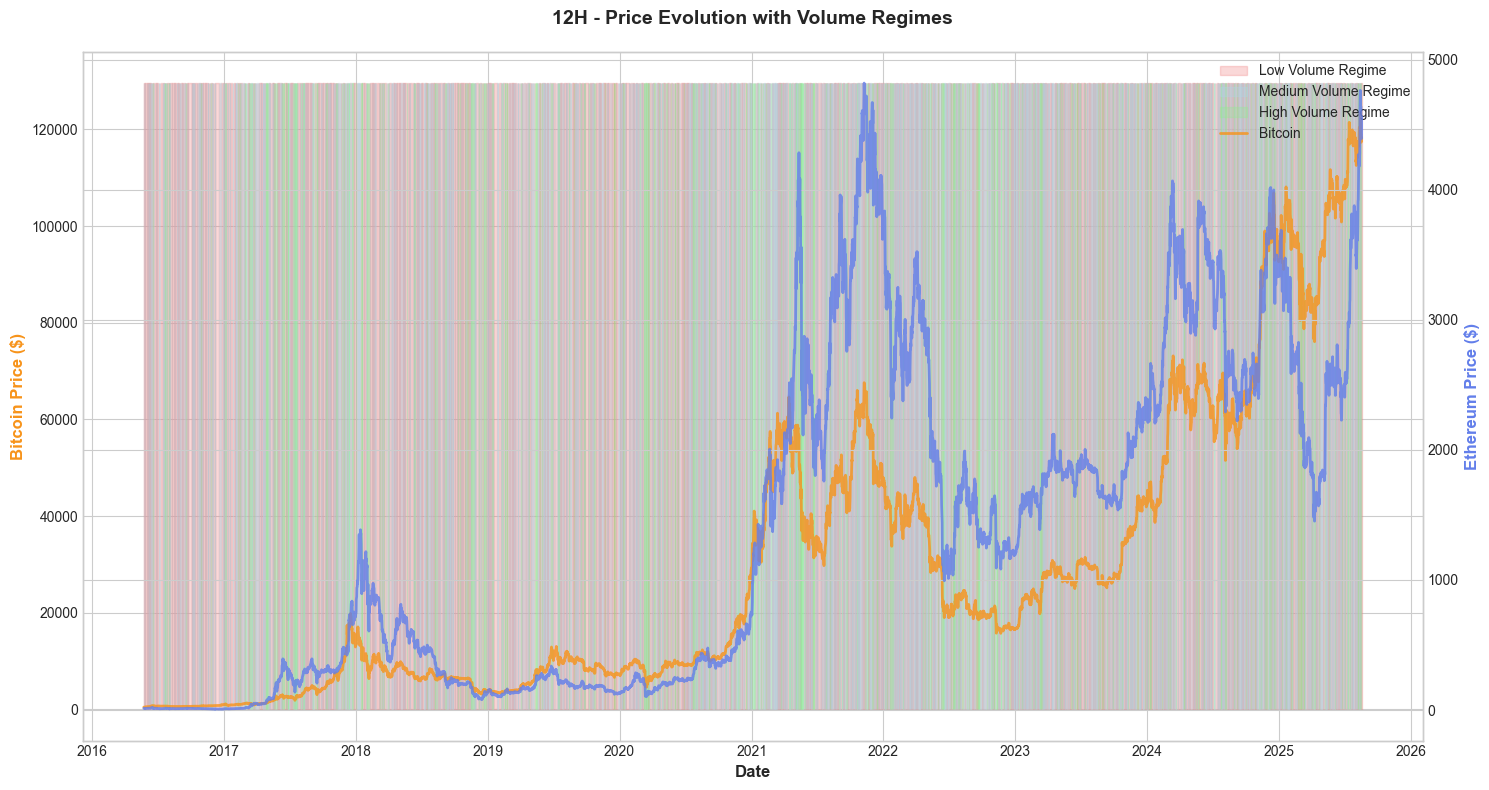

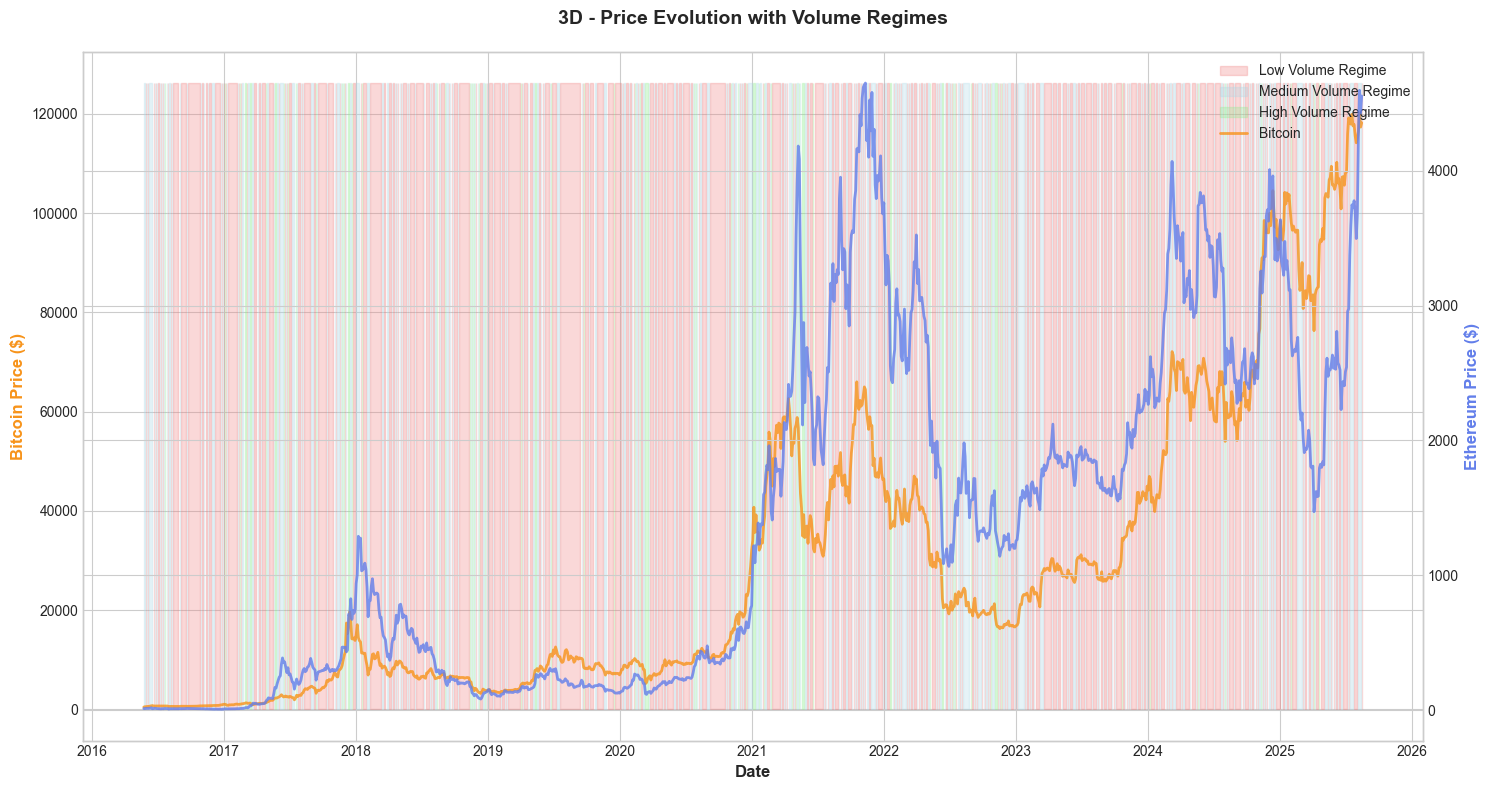

2. Plotting trading signals...


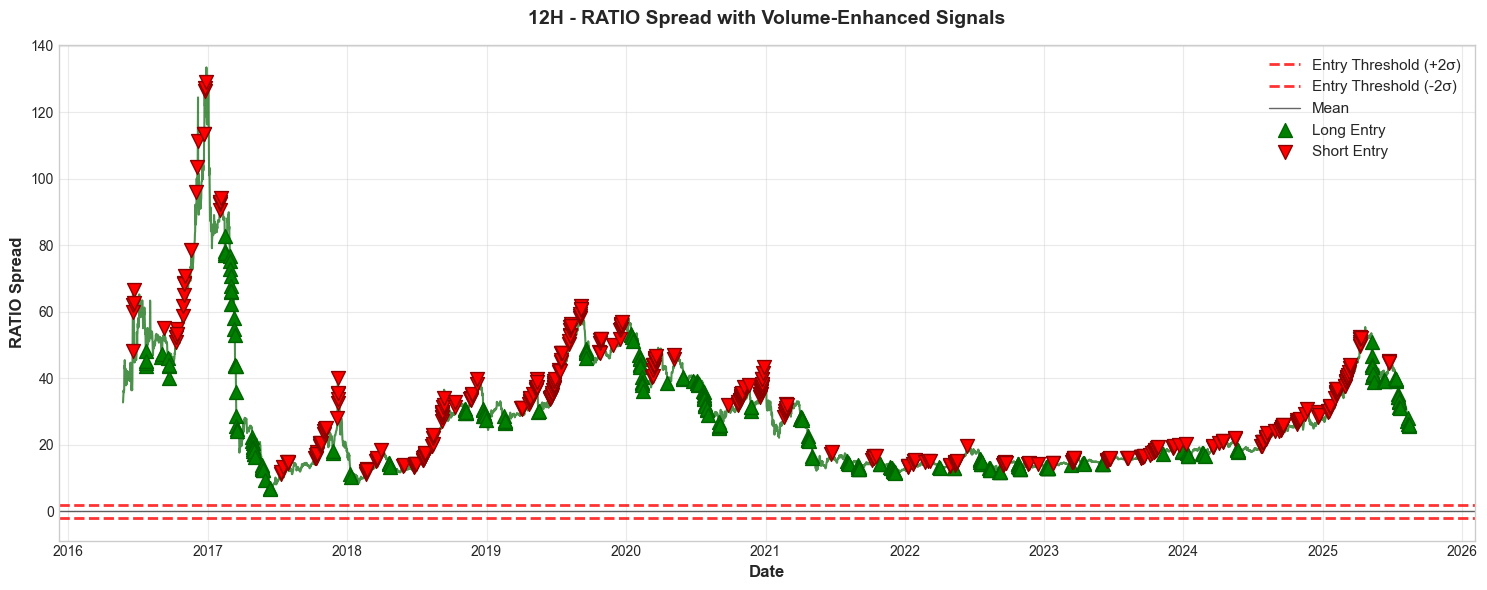

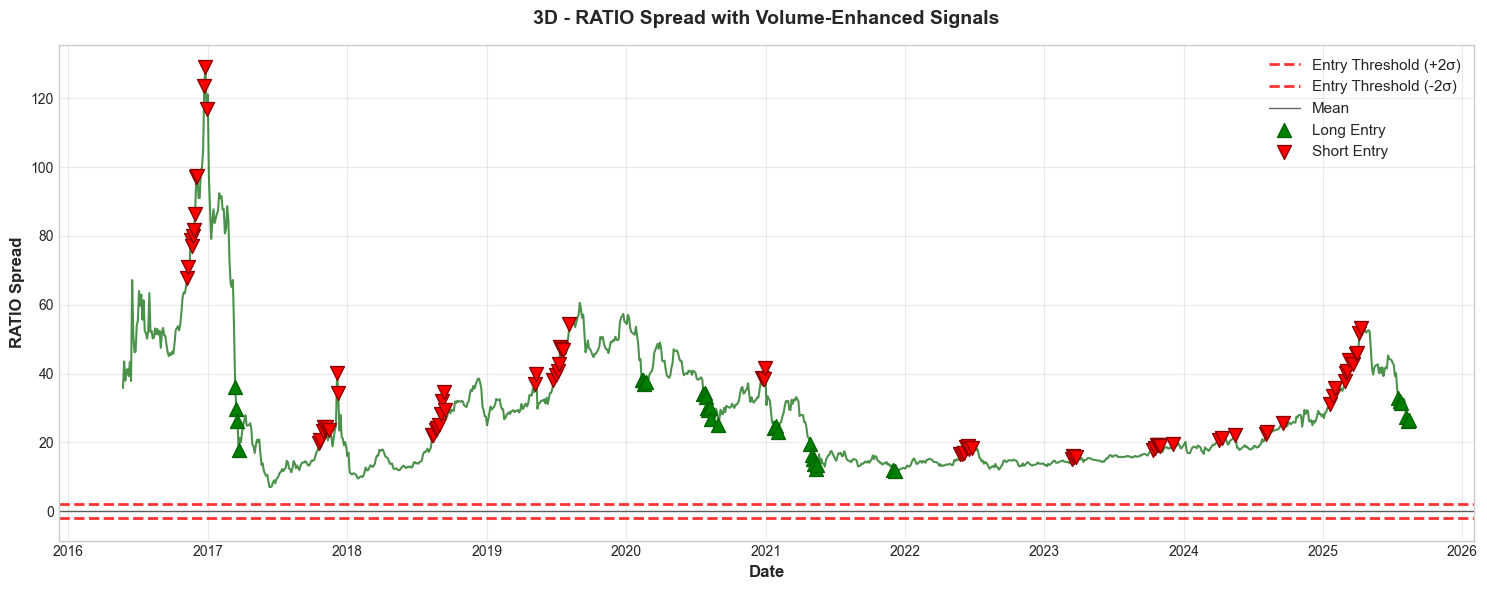

3. Creating volume analysis ...


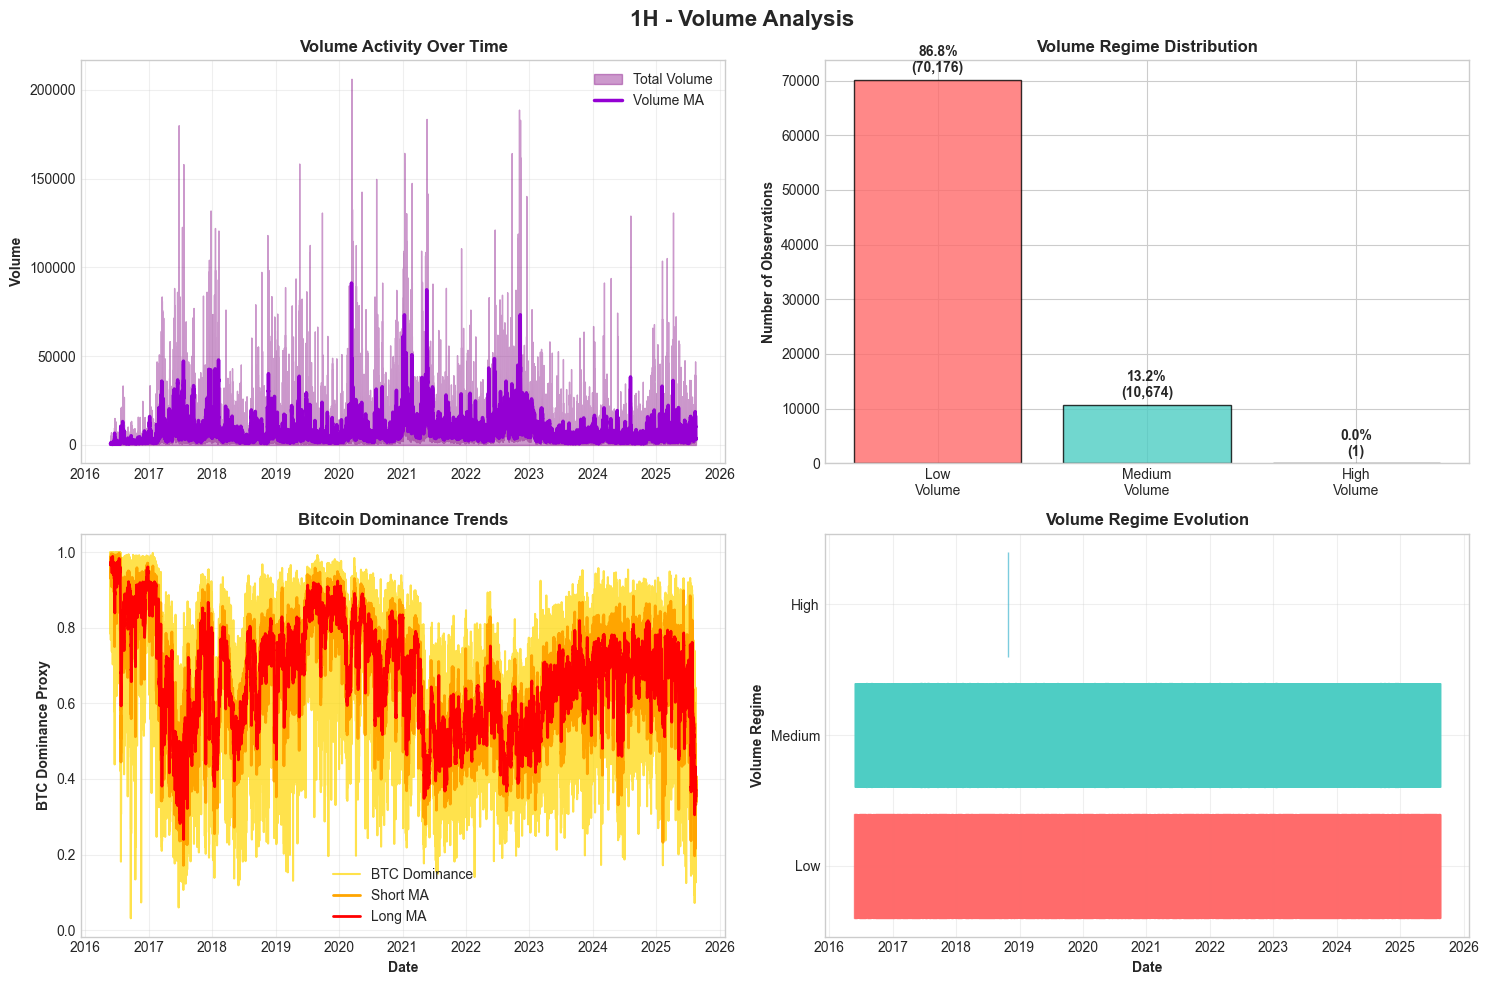

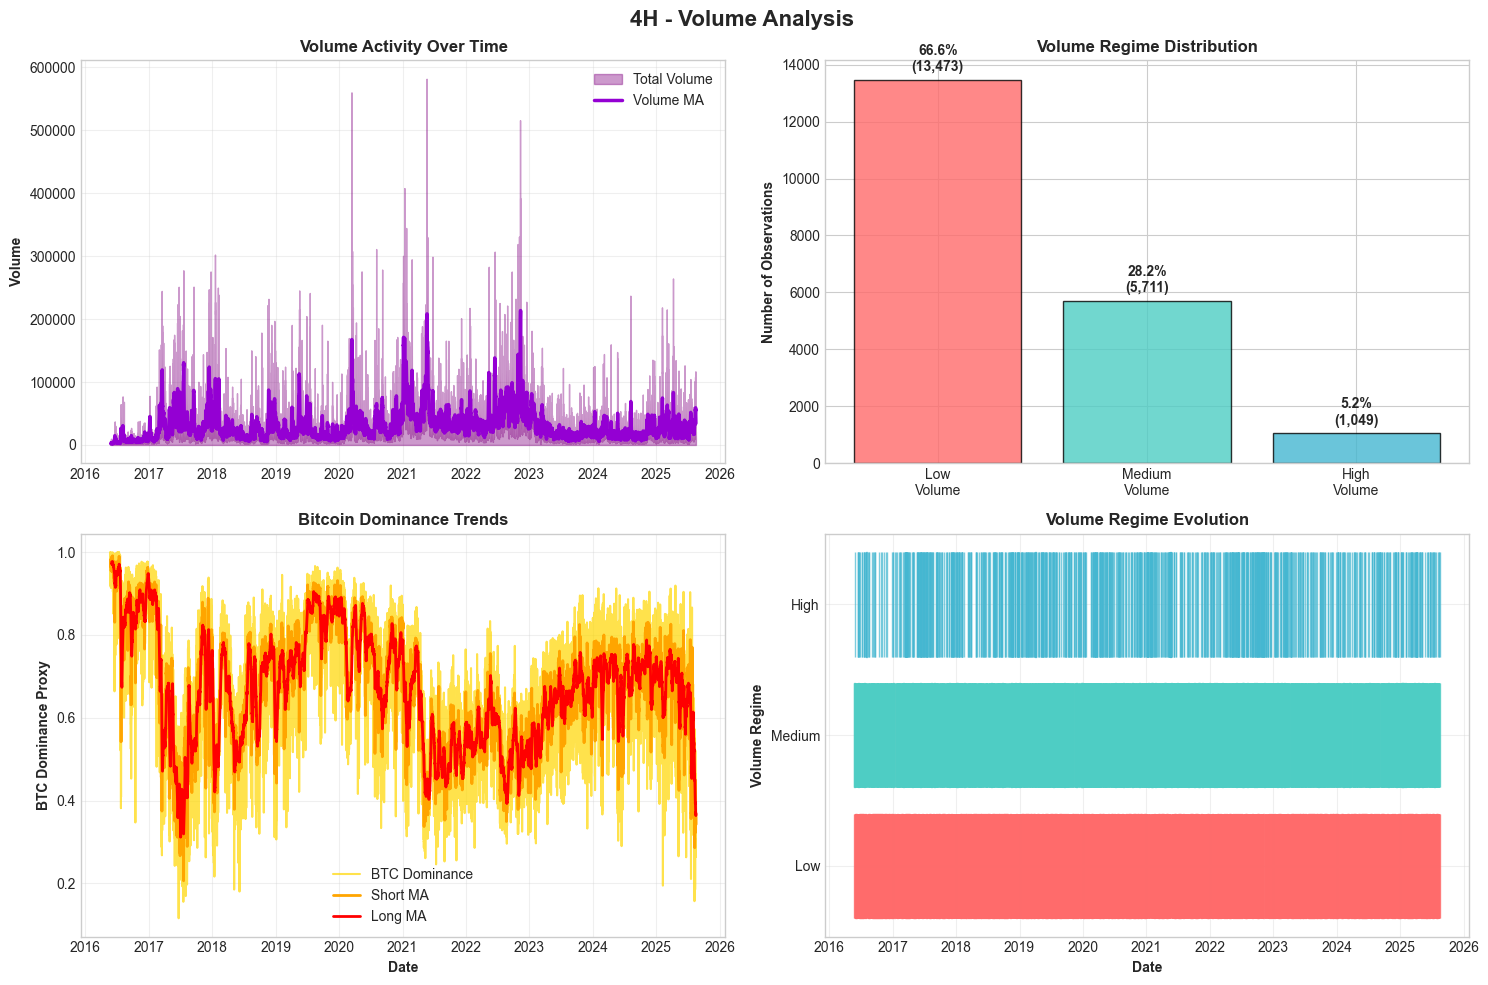

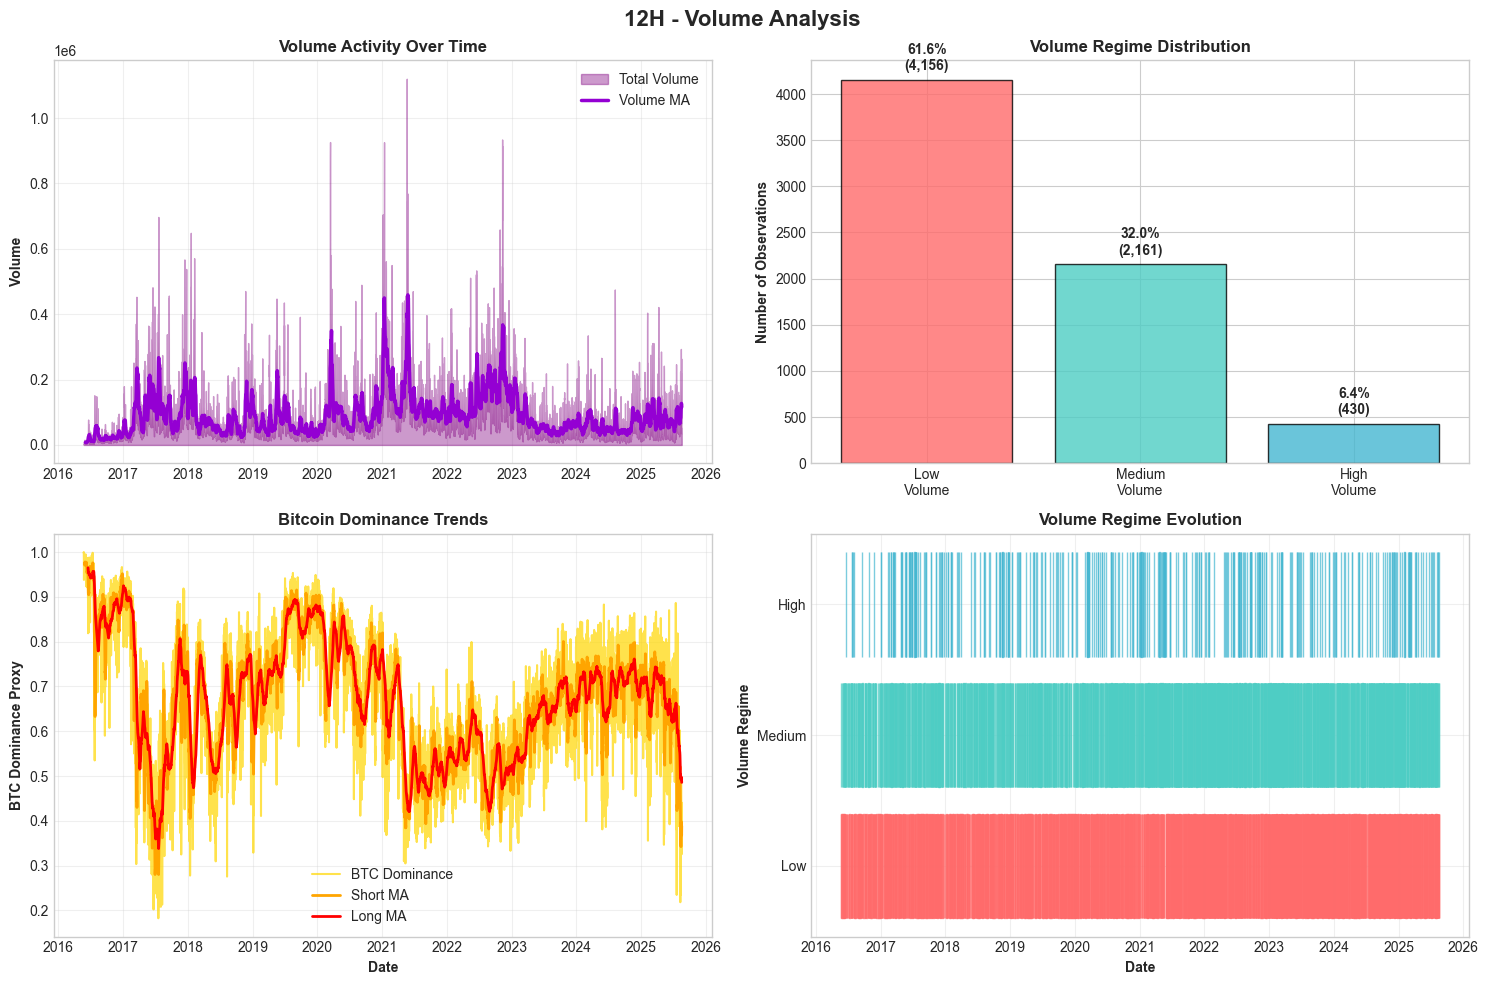

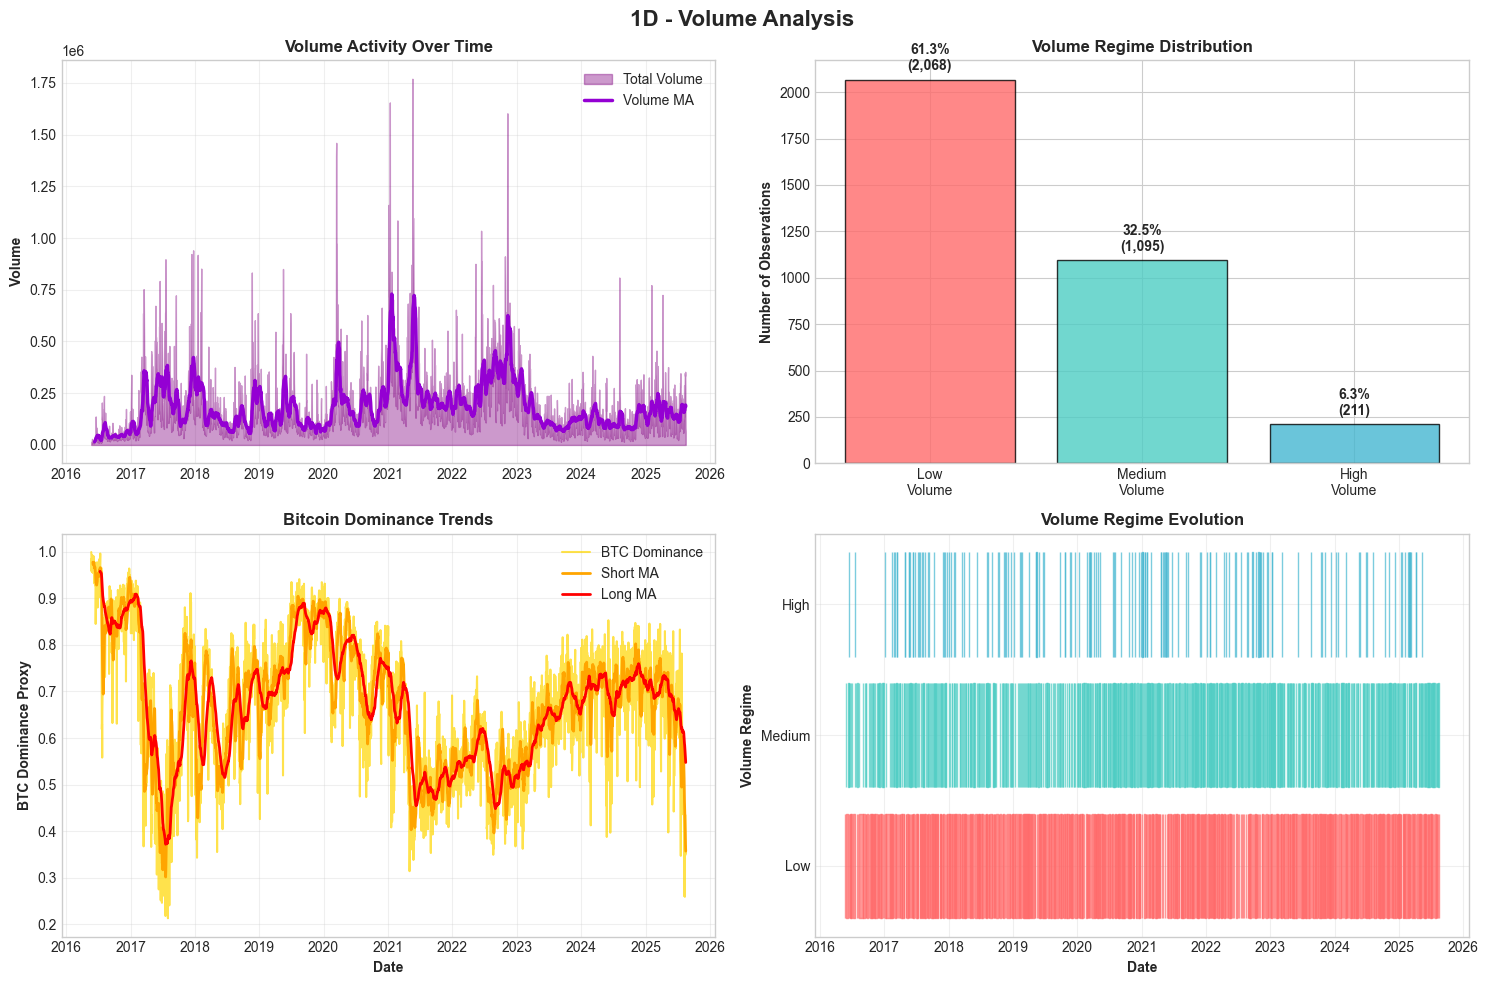

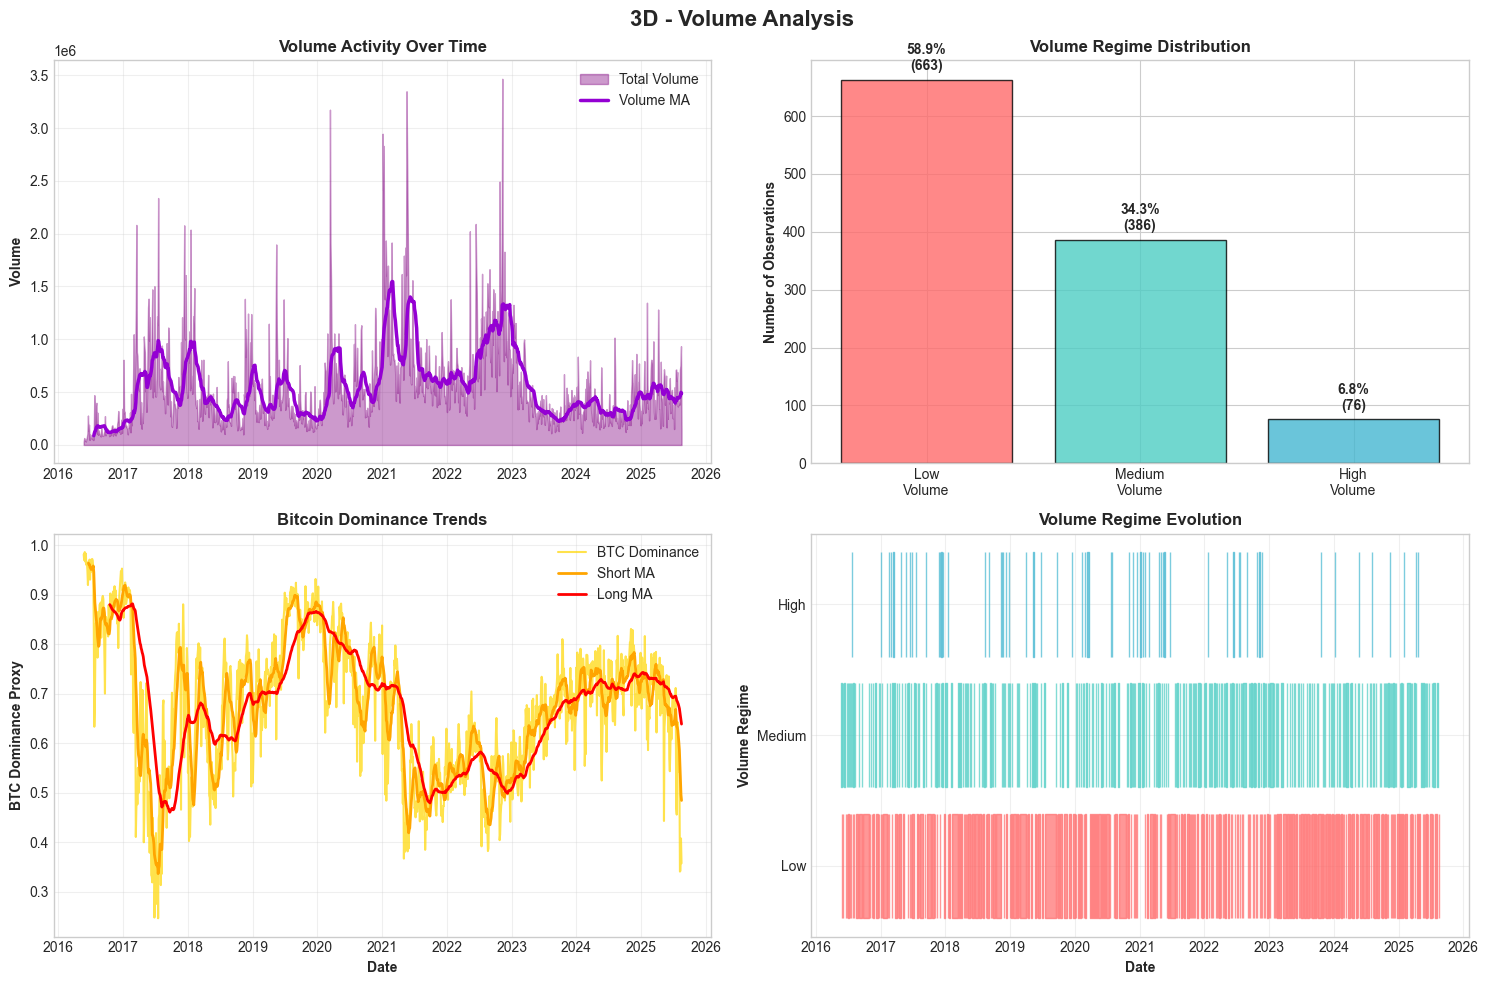

4. Comparing cointegration results...


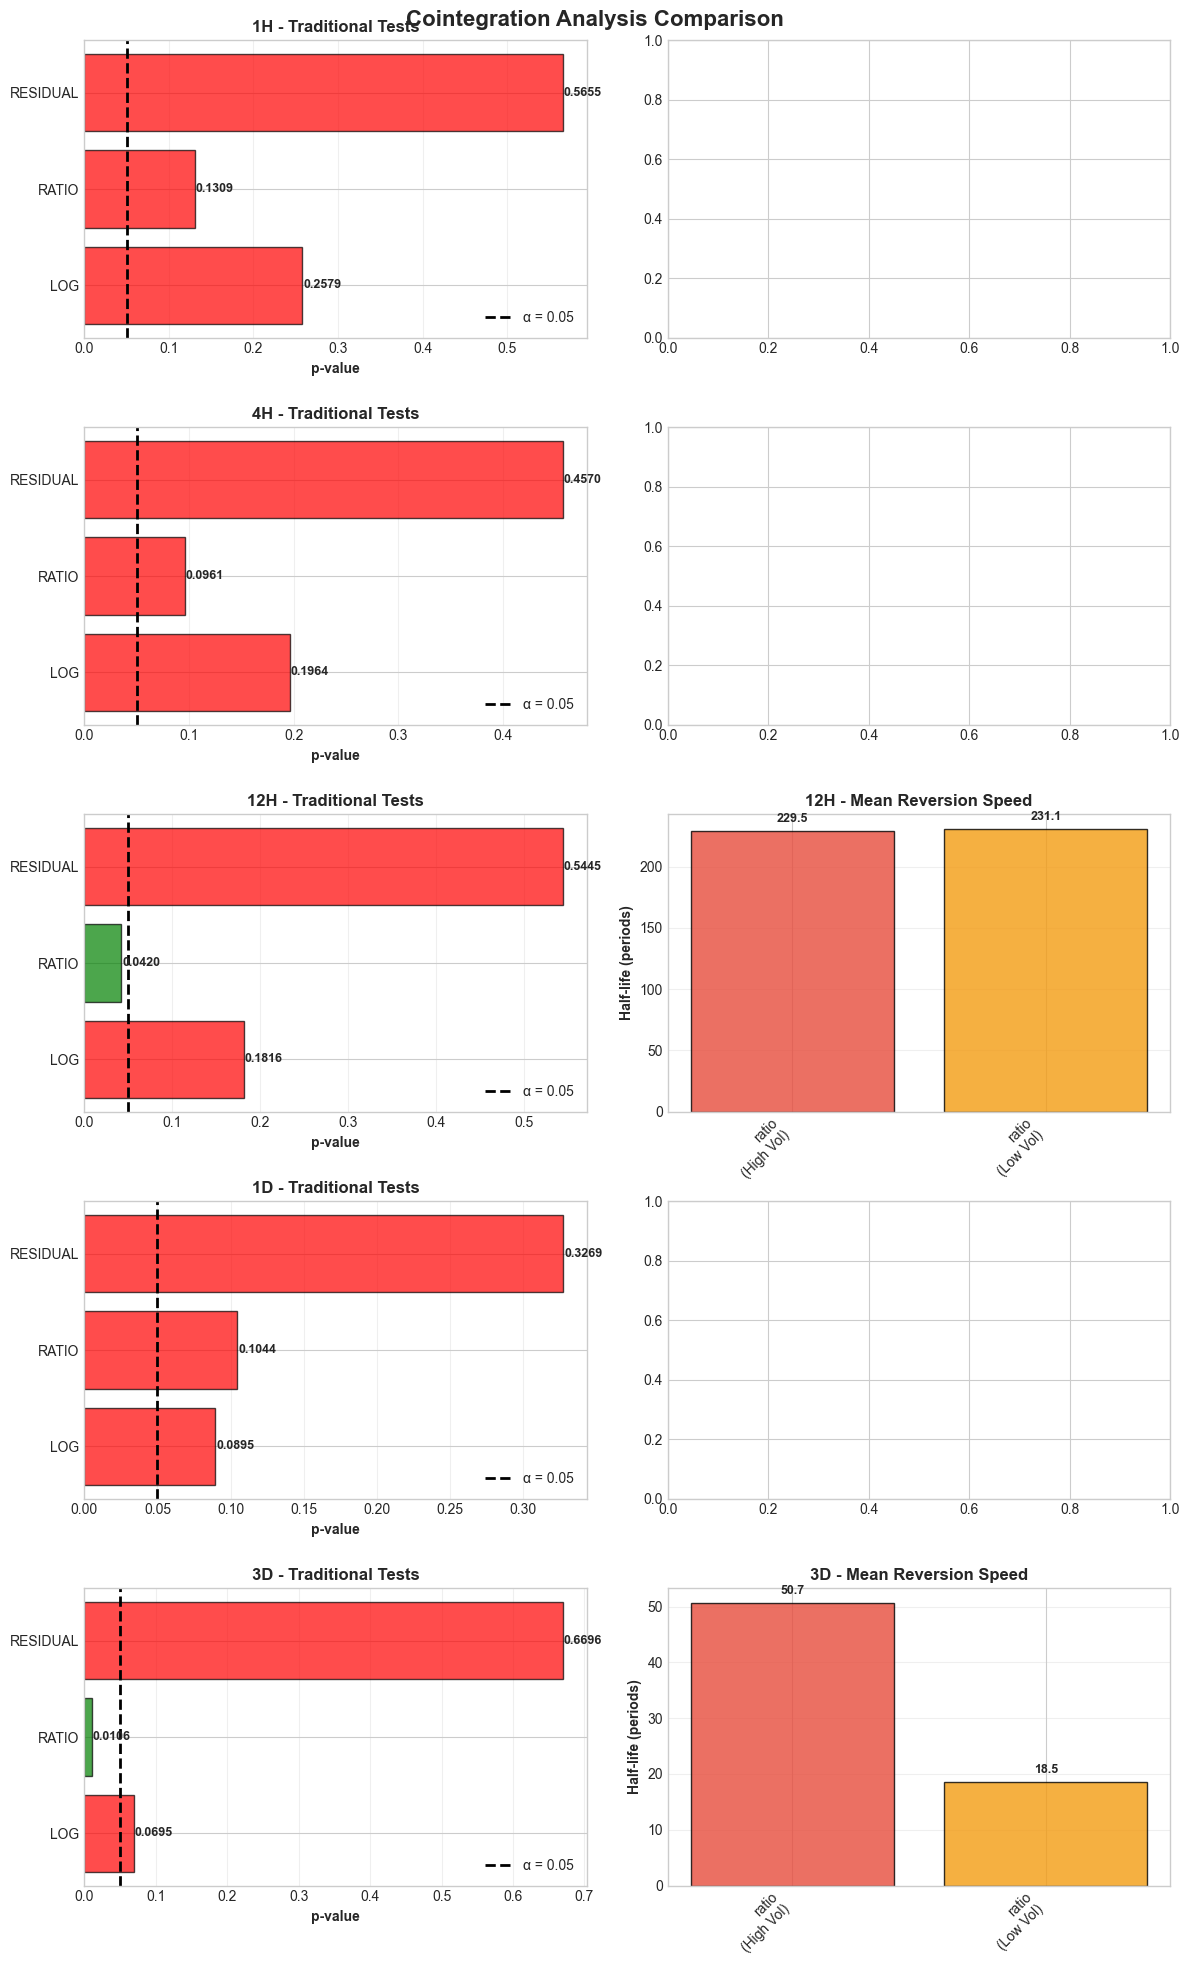

5. Analyzing signal performance...


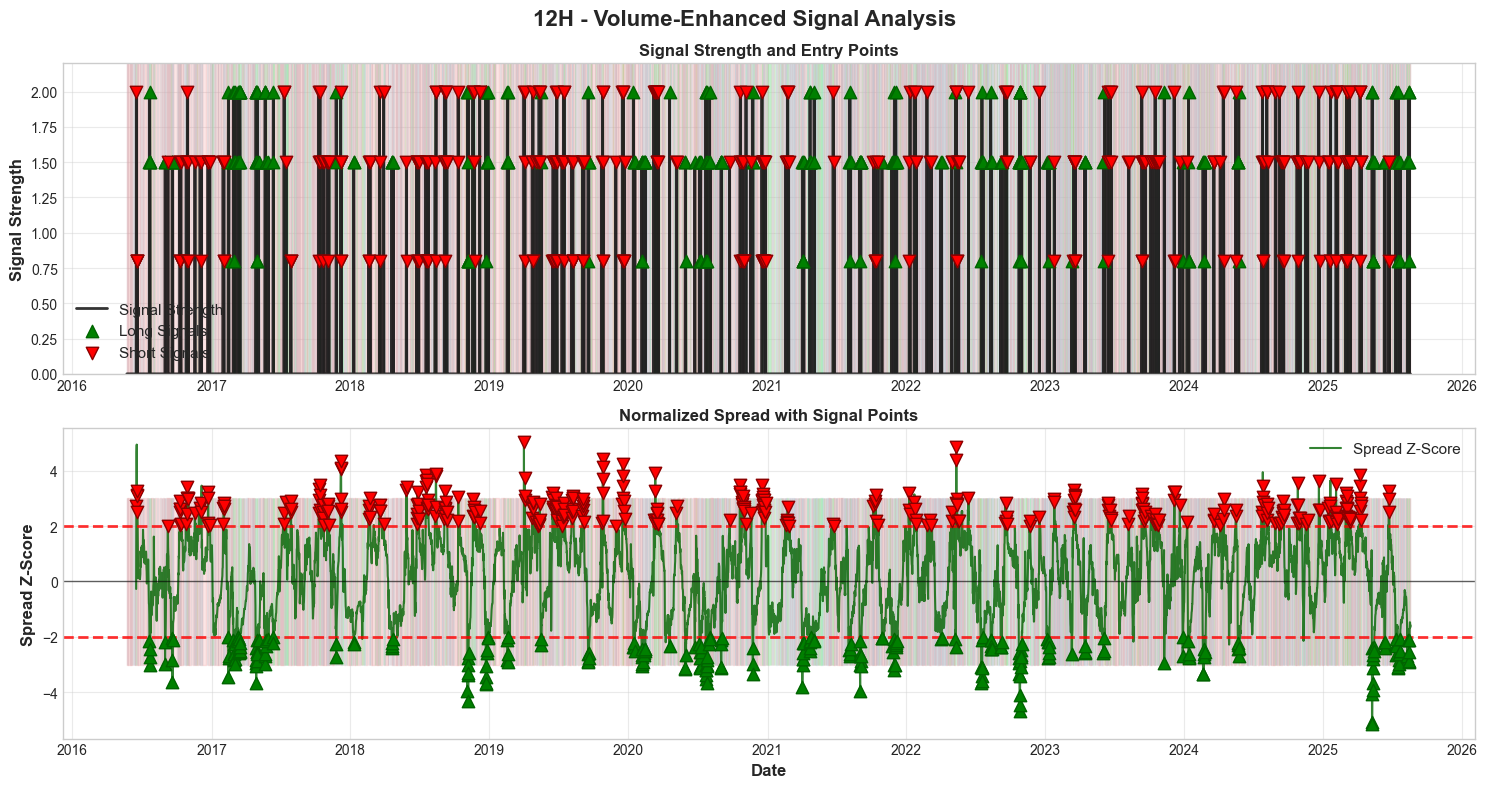

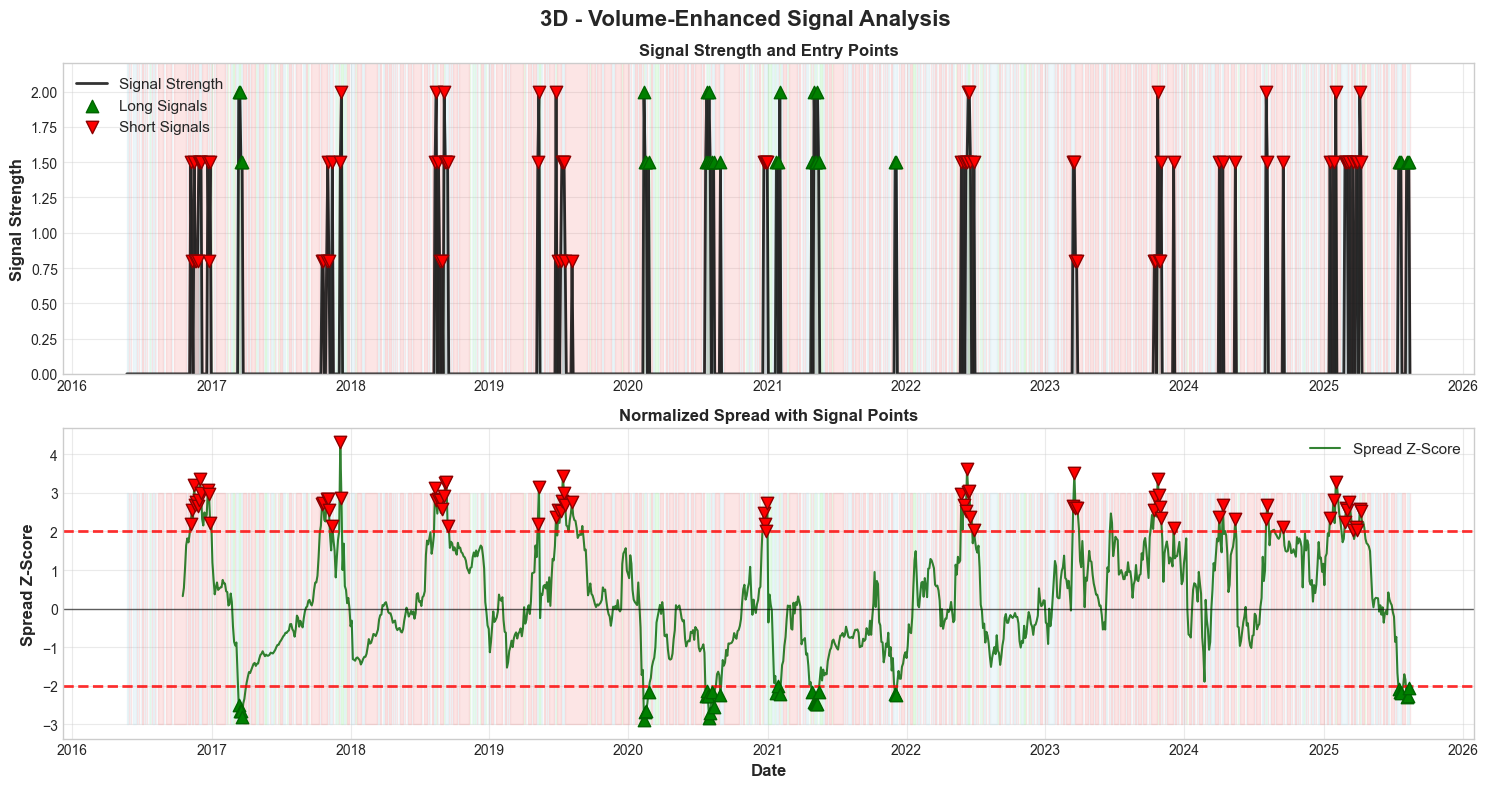

6. Regime-conditional analysis...


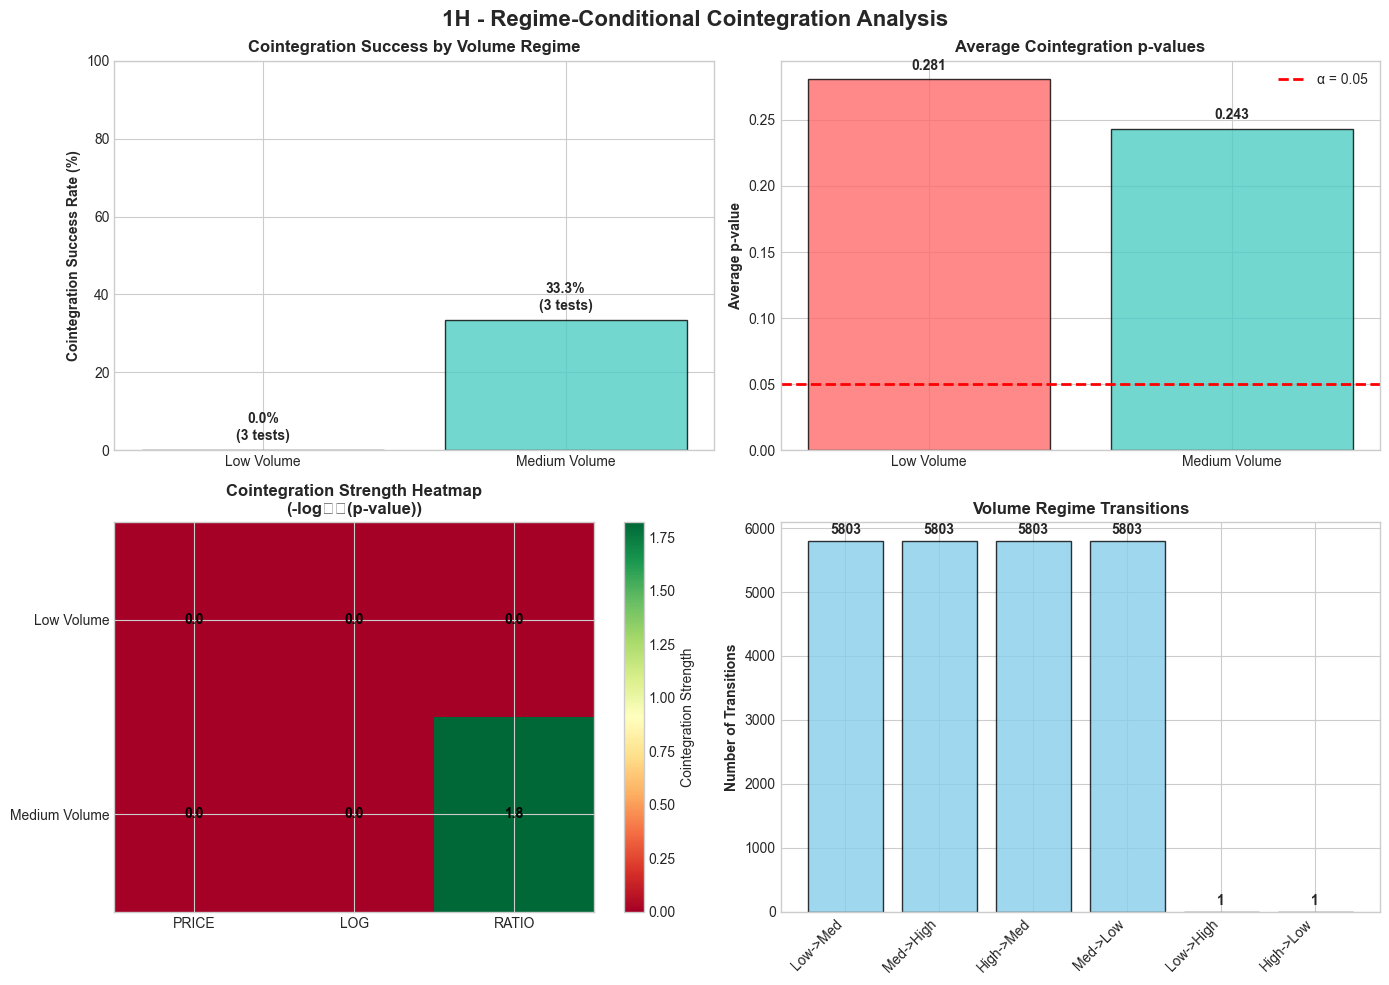

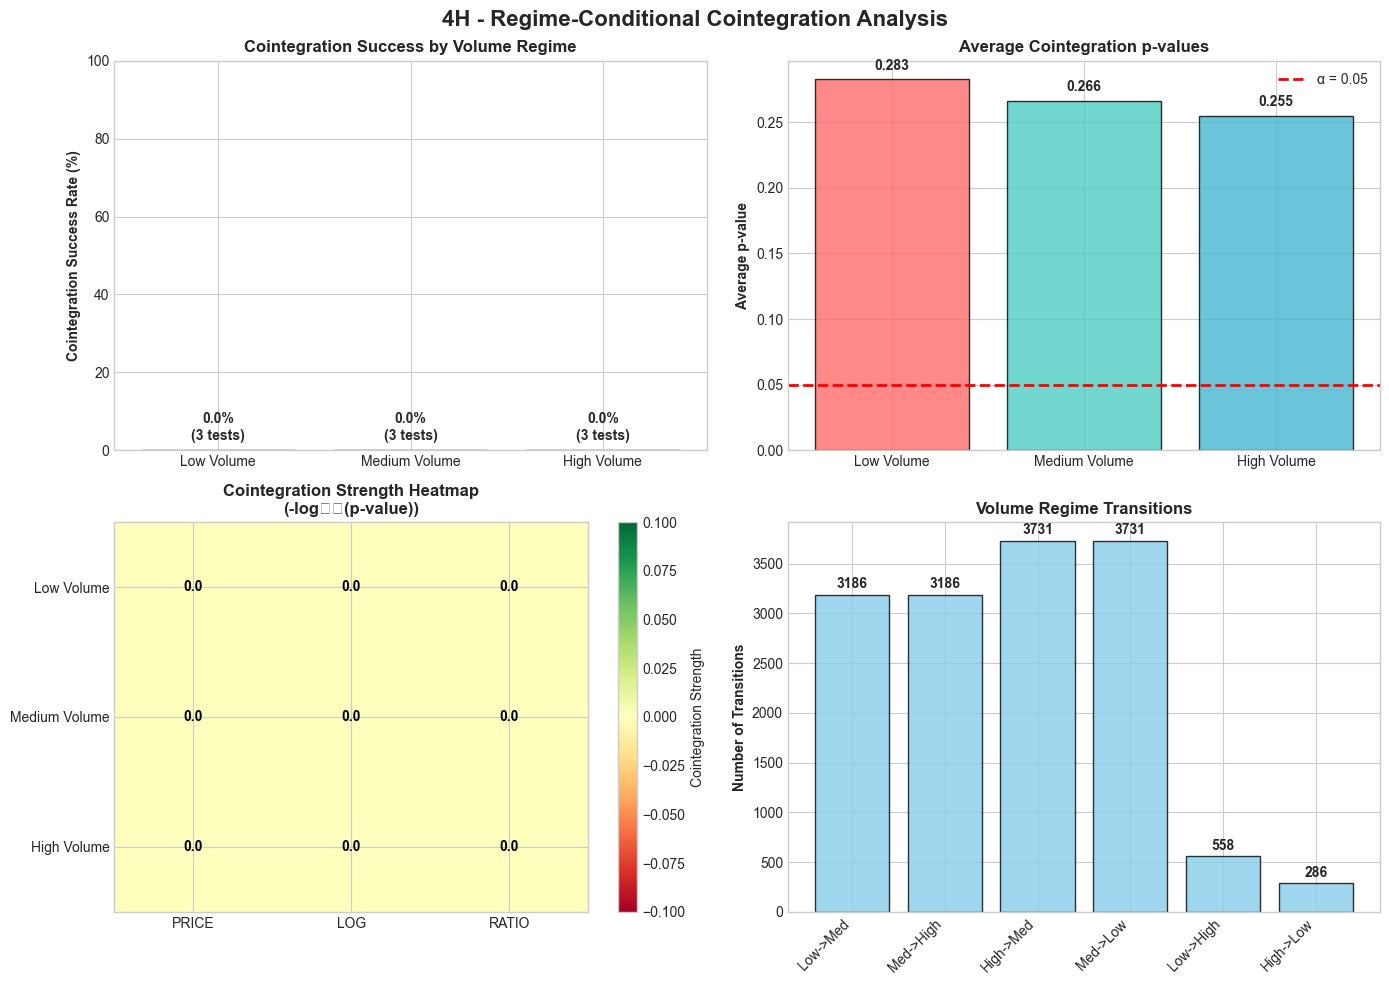

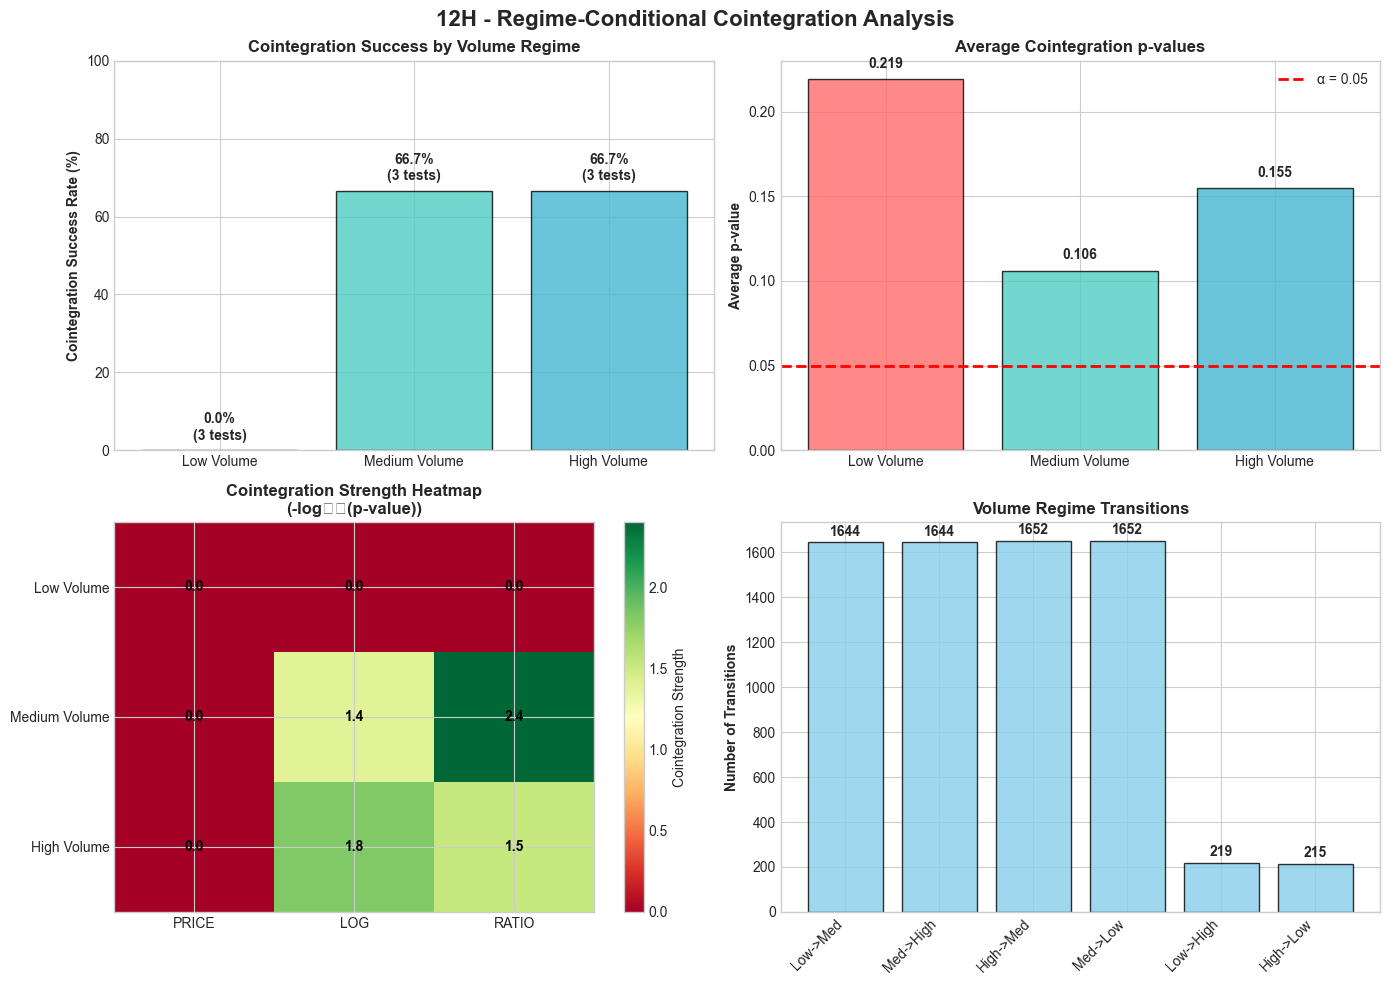

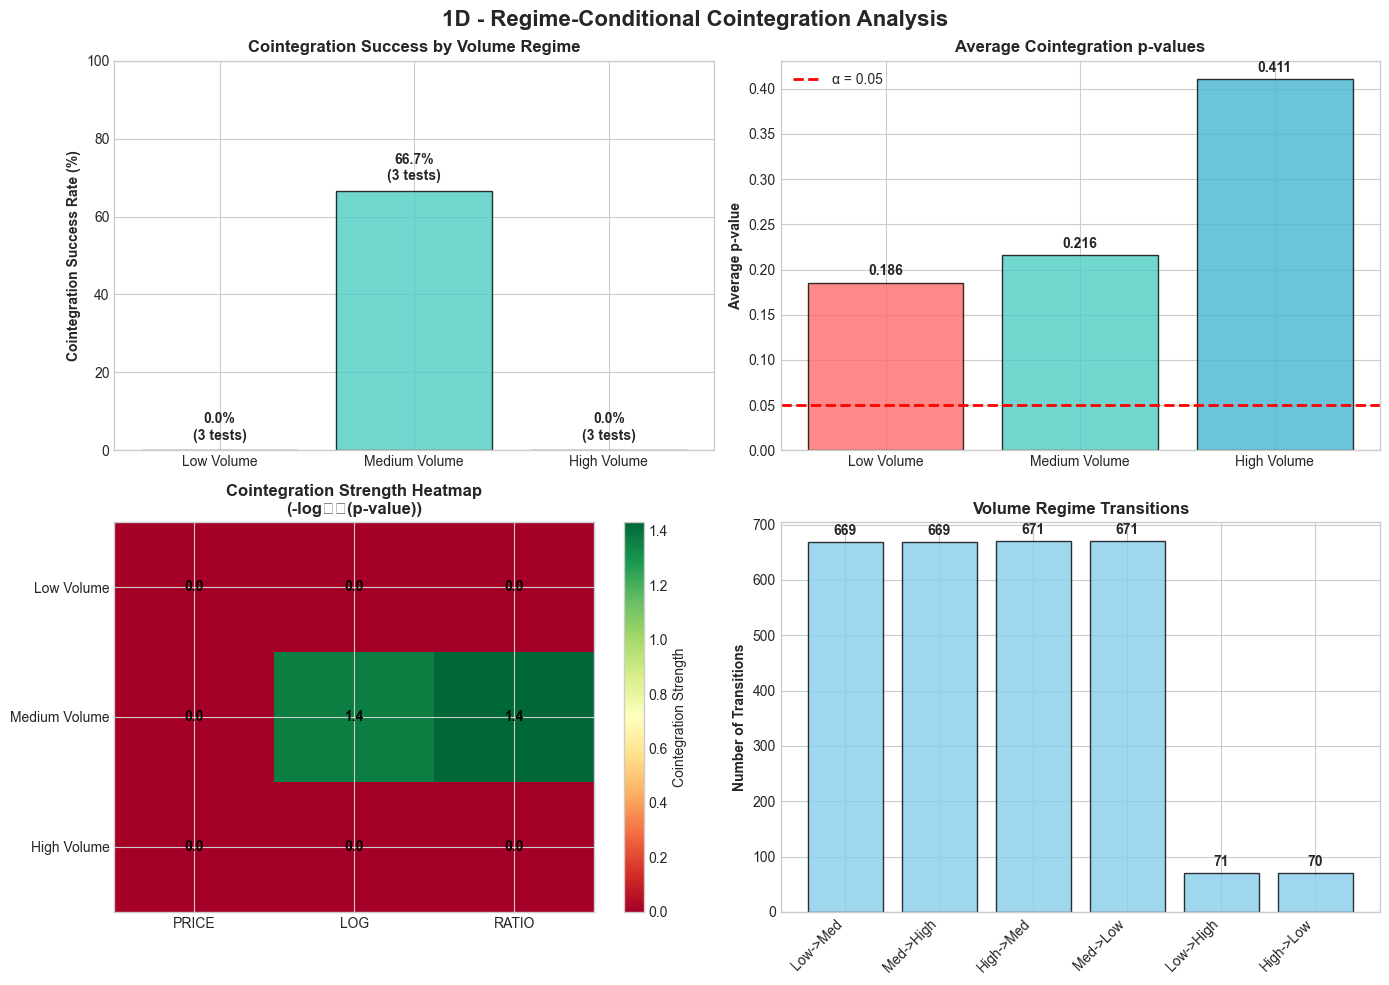

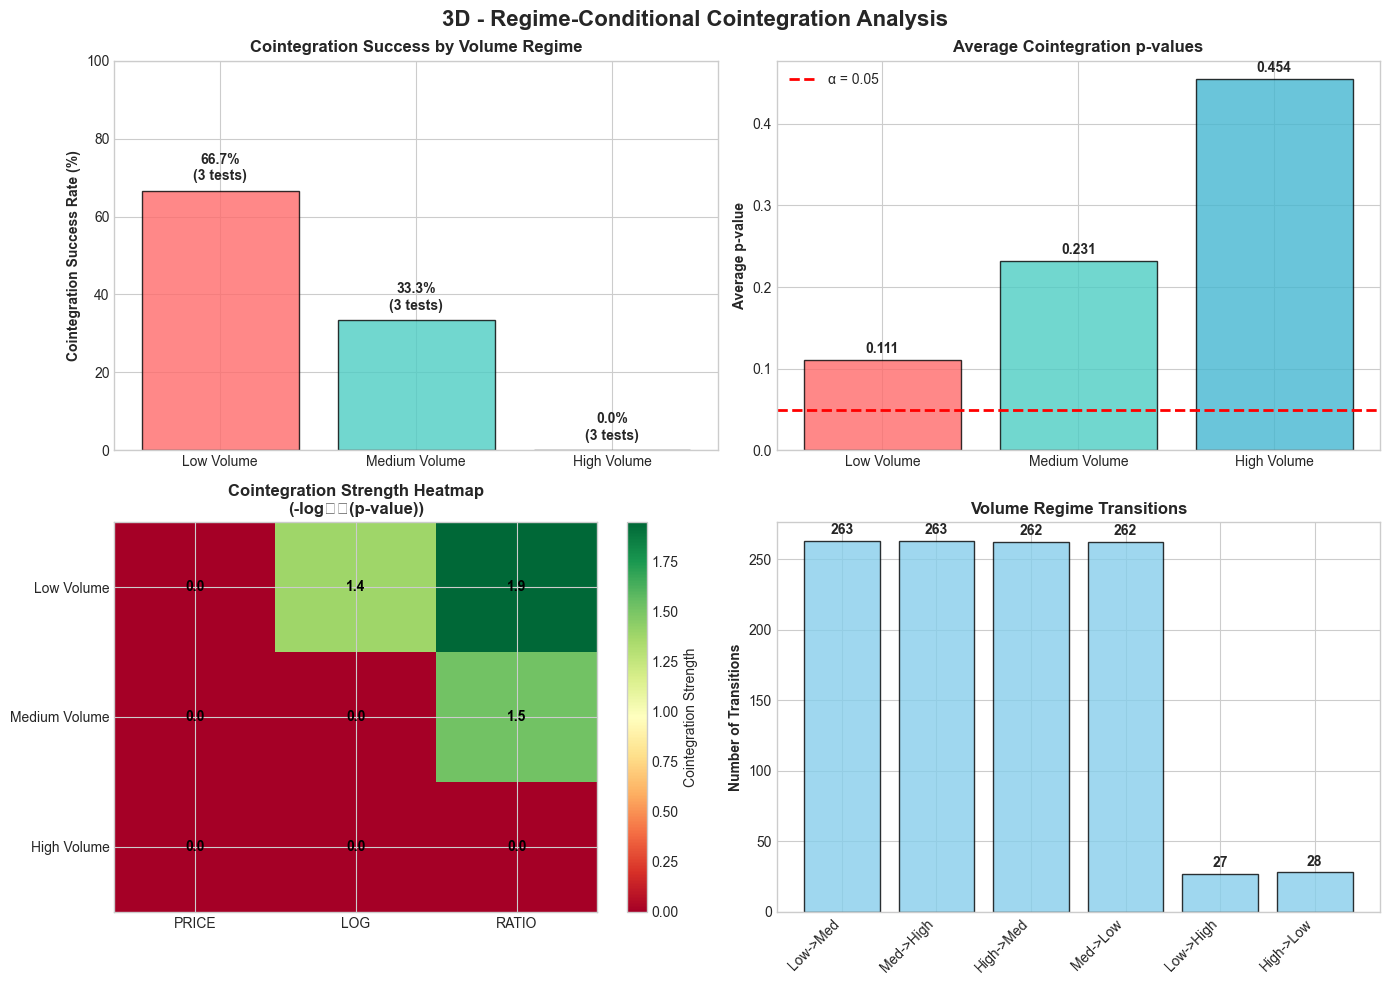


All visualizations completed!


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def plot_prices_with_volume_regimes(enhanced_results, figsize=(15, 8)):
    """
    Plot price series with volume regime backgrounds - one plot per timeframe.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result and any(s.get('is_cointegrated', False) 
                        for s in result['traditional_results'].values())]
    
    for tf_label in viable_timeframes:
        result = enhanced_results[tf_label]
        timestamps_pd = pd.to_datetime(result['timestamps'])
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Volume regime background colors
        regime_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}
        regime_labels = {0: 'Low Volume', 1: 'Medium Volume', 2: 'High Volume'}
        volume_regimes = result['volume_regimes']
        
        # Add regime backgrounds
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax.fill_between(timestamps_pd, 
                               min(result['btc_prices'].min(), result['eth_prices'].min()) * 0.95,
                               max(result['btc_prices'].max(), result['eth_prices'].max()) * 1.05,
                               where=mask, alpha=0.3, color=regime_colors[regime],
                               label=f'{regime_labels[regime]} Regime')
        
        # Plot prices on separate y-axes
        ax2 = ax.twinx()
        
        line1 = ax.plot(timestamps_pd, result['btc_prices'], 
                       label='Bitcoin', color='#f7931a', linewidth=2, alpha=0.8)
        line2 = ax2.plot(timestamps_pd, result['eth_prices'], 
                        label='Ethereum', color='#627eea', linewidth=2, alpha=0.8)
        
        # Formatting
        ax.set_ylabel('Bitcoin Price ($)', color='#f7931a', fontweight='bold', fontsize=12)
        ax2.set_ylabel('Ethereum Price ($)', color='#627eea', fontweight='bold', fontsize=12)
        ax.set_xlabel('Date', fontweight='bold', fontsize=12)
        
        # Title and legend
        plt.title(f'{tf_label} - Price Evolution with Volume Regimes', 
                 fontweight='bold', fontsize=14, pad=20)
        
        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='upper left', fontsize=11)
        ax.legend(loc='upper right', fontsize=10)  # Volume regime legend
        
        plt.tight_layout()
        plt.show()

def plot_spread_with_signals(enhanced_results, figsize=(15, 6)):
    """
    Plot cointegration spreads with volume-enhanced trading signals.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result and any(s.get('is_cointegrated', False) 
                        for s in result['traditional_results'].values())]
    
    for tf_label in viable_timeframes:
        result = enhanced_results[tf_label]
        timestamps_pd = pd.to_datetime(result['timestamps'])
        
        # Find best cointegrated spread
        best_spread = min(
            (s for s in result['traditional_results'] if result['traditional_results'][s].get('is_cointegrated', False)),
            key=lambda x: result['traditional_results'][x]['p_value'],
            default=None
        )
        
        if not best_spread:
            continue
            
        spread_data = result['traditional_results'][best_spread]['values']
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot spread
        ax.plot(timestamps_pd, spread_data, color='darkgreen', alpha=0.7, linewidth=1.5)
        
        # Add trading thresholds
        ax.axhline(2, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Entry Threshold (+2σ)')
        ax.axhline(-2, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Entry Threshold (-2σ)')
        ax.axhline(0, color='black', linestyle='-', alpha=0.6, linewidth=1, label='Mean')
        
        # Add signals if available
        if result['signals'] is not None:
            signals = result['signals']
            long_signals = signals['enhanced_long']
            short_signals = signals['enhanced_short']
            
            if np.any(long_signals):
                ax.scatter(timestamps_pd[long_signals], spread_data[long_signals], 
                          color='green', marker='^', s=100, label='Long Entry', 
                          zorder=5, edgecolors='darkgreen', linewidth=1)
            
            if np.any(short_signals):
                ax.scatter(timestamps_pd[short_signals], spread_data[short_signals], 
                          color='red', marker='v', s=100, label='Short Entry', 
                          zorder=5, edgecolors='darkred', linewidth=1)
        
        # Formatting
        ax.set_ylabel(f'{best_spread.upper()} Spread', fontweight='bold', fontsize=12)
        ax.set_xlabel('Date', fontweight='bold', fontsize=12)
        ax.set_title(f'{tf_label} - {best_spread.upper()} Spread with Volume-Enhanced Signals', 
                    fontweight='bold', fontsize=14, pad=15)
        
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.4)
        
        plt.tight_layout()
        plt.show()

def plot_volume_analysis(enhanced_results, figsize=(15, 10)):
    """
    Comprehensive volume analysis plots.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result]
    
    for tf_label in viable_timeframes:
        result = enhanced_results[tf_label]
        timestamps_pd = pd.to_datetime(result['timestamps'])
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'{tf_label} - Volume Analysis ', fontweight='bold', fontsize=16)
        
        # Plot 1: Volume time series with moving average
        total_volume = result['volume_metrics']['total_volume']
        volume_ma = result['volume_metrics']['volume_ma']
        
        ax1.fill_between(timestamps_pd, 0, total_volume, alpha=0.4, color='purple', label='Total Volume')
        ax1.plot(timestamps_pd, volume_ma, color='darkviolet', linewidth=2.5, label='Volume MA')
        ax1.set_ylabel('Volume', fontweight='bold')
        ax1.set_title('Volume Activity Over Time', fontweight='bold', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Volume regime distribution
        regime_dist = result['regime_distribution']
        regime_labels = ['Low\nVolume', 'Medium\nVolume', 'High\nVolume']
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        
        counts = [regime_dist.get(i, 0) for i in range(3)]
        total_obs = sum(regime_dist.values())
        percentages = [100 * count / total_obs for count in counts]
        
        bars = ax2.bar(regime_labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax2.set_ylabel('Number of Observations', fontweight='bold')
        ax2.set_title('Volume Regime Distribution', fontweight='bold', fontsize=12)
        
        # Add percentage labels on bars
        for bar, pct, count in zip(bars, percentages, counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_obs*0.01,
                    f'{pct:.1f}%\n({count:,})', ha='center', va='bottom', fontweight='bold')
        
        # Plot 3: Bitcoin dominance trends
        dominance = result['dominance_metrics']['dominance_proxy']
        dom_ma_short = result['dominance_metrics']['dominance_ma_short']
        dom_ma_long = result['dominance_metrics']['dominance_ma_long']
        
        ax3.plot(timestamps_pd, dominance, color='gold', linewidth=1.5, alpha=0.7, label='BTC Dominance')
        ax3.plot(timestamps_pd, dom_ma_short, color='orange', linewidth=2, label='Short MA')
        ax3.plot(timestamps_pd, dom_ma_long, color='red', linewidth=2, label='Long MA')
        ax3.set_ylabel('BTC Dominance Proxy', fontweight='bold')
        ax3.set_xlabel('Date', fontweight='bold')
        ax3.set_title('Bitcoin Dominance Trends', fontweight='bold', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Volume regime time series
        volume_regimes = result['volume_regimes']
        regime_colors = {0: '#ff6b6b', 1: '#4ecdc4', 2: '#45b7d1'}
        
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax4.fill_between(timestamps_pd, regime-0.4, regime+0.4, 
                               where=mask, alpha=0.7, color=regime_colors[regime])
        
        ax4.set_ylabel('Volume Regime', fontweight='bold')
        ax4.set_xlabel('Date', fontweight='bold')
        ax4.set_title('Volume Regime Evolution', fontweight='bold', fontsize=12)
        ax4.set_yticks([0, 1, 2])
        ax4.set_yticklabels(['Low', 'Medium', 'High'])
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def plot_cointegration_comparison(enhanced_results, figsize=(12, 8)):
    """
    Compare traditional vs volume-conditional cointegration results.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result]
    
    n_timeframes = len(viable_timeframes)
    fig, axes = plt.subplots(n_timeframes, 2, figsize=(figsize[0], figsize[1] * n_timeframes/2))
    
    if n_timeframes == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Cointegration Analysis Comparison', fontweight='bold', fontsize=16)
    
    for i, tf_label in enumerate(viable_timeframes):
        result = enhanced_results[tf_label]
        
        # Traditional cointegration results
        trad_results = result['traditional_results']
        spreads = list(trad_results.keys())
        p_values = [trad_results[s]['p_value'] for s in spreads]
        is_cointegrated = [trad_results[s]['is_cointegrated'] for s in spreads]
        
        colors = ['green' if coint else 'red' for coint in is_cointegrated]
        
        ax1 = axes[i, 0] if n_timeframes > 1 else axes[0]
        bars = ax1.barh(range(len(spreads)), p_values, color=colors, alpha=0.7, edgecolor='black')
        ax1.axvline(0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')
        ax1.set_yticks(range(len(spreads)))
        ax1.set_yticklabels([s.upper() for s in spreads])
        ax1.set_xlabel('p-value', fontweight='bold')
        ax1.set_title(f'{tf_label} - Traditional Tests', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add p-value labels
        for j, (bar, pval) in enumerate(zip(bars, p_values)):
            ax1.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{pval:.4f}', va='center', fontweight='bold', fontsize=9)
        
        # Half-life comparison
        ax2 = axes[i, 1] if n_timeframes > 1 else axes[1]
        
        if result['enhanced_half_lives']:
            all_half_lives = []
            all_labels = []
            all_colors = []
            
            for spread_name, hl_metrics in result['enhanced_half_lives'].items():
                # Traditional
                if spread_name in trad_results and trad_results[spread_name].get('half_life'):
                    all_half_lives.append(trad_results[spread_name]['half_life'])
                    all_labels.append(f'{spread_name}\n(Traditional)')
                    all_colors.append('#3498db')
                
                # High volume
                if hl_metrics.get('high_volume_half_life'):
                    all_half_lives.append(hl_metrics['high_volume_half_life'])
                    all_labels.append(f'{spread_name}\n(High Vol)')
                    all_colors.append('#e74c3c')
                
                # Low volume
                if hl_metrics.get('low_volume_half_life'):
                    all_half_lives.append(hl_metrics['low_volume_half_life'])
                    all_labels.append(f'{spread_name}\n(Low Vol)')
                    all_colors.append('#f39c12')
            
            if all_half_lives:
                bars = ax2.bar(range(len(all_half_lives)), all_half_lives, 
                              color=all_colors, alpha=0.8, edgecolor='black')
                ax2.set_xticks(range(len(all_labels)))
                ax2.set_xticklabels(all_labels, rotation=45, ha='right')
                ax2.set_ylabel('Half-life (periods)', fontweight='bold')
                ax2.set_title(f'{tf_label} - Mean Reversion Speed', fontweight='bold')
                ax2.grid(True, alpha=0.3, axis='y')
                
                # Add value labels
                for bar, hl in zip(bars, all_half_lives):
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(all_half_lives)*0.02,
                            f'{hl:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_signal_analysis(enhanced_results, figsize=(15, 8)):
    """
    Detailed signal analysis and performance visualization.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result and result.get('signals') is not None]
    
    for tf_label in viable_timeframes:
        result = enhanced_results[tf_label]
        timestamps_pd = pd.to_datetime(result['timestamps'])
        signals = result['signals']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        fig.suptitle(f'{tf_label} - Volume-Enhanced Signal Analysis', fontweight='bold', fontsize=16)
        
        # Volume regime background
        volume_regimes = result['volume_regimes']
        regime_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}
        
        for regime in [0, 1, 2]:
            mask = volume_regimes == regime
            if np.any(mask):
                ax1.fill_between(timestamps_pd, 0, 3, where=mask, alpha=0.2, 
                               color=regime_colors[regime])
                ax2.fill_between(timestamps_pd, -3, 3, where=mask, alpha=0.2, 
                               color=regime_colors[regime])
        
        # Plot 1: Signal strength over time
        signal_strength = signals['signal_strength']
        ax1.plot(timestamps_pd, signal_strength, color='black', linewidth=2, 
                label='Signal Strength', alpha=0.8)
        ax1.fill_between(timestamps_pd, 0, signal_strength, alpha=0.3, color='gray')
        
        # Mark actual signals
        long_mask = signals['enhanced_long']
        short_mask = signals['enhanced_short']
        
        if np.any(long_mask):
            ax1.scatter(timestamps_pd[long_mask], signal_strength[long_mask], 
                       color='green', marker='^', s=80, label='Long Signals', 
                       zorder=5, edgecolors='darkgreen')
        
        if np.any(short_mask):
            ax1.scatter(timestamps_pd[short_mask], signal_strength[short_mask], 
                       color='red', marker='v', s=80, label='Short Signals', 
                       zorder=5, edgecolors='darkred')
        
        ax1.set_ylabel('Signal Strength', fontweight='bold', fontsize=12)
        ax1.set_title('Signal Strength and Entry Points', fontweight='bold', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.4)
        ax1.set_ylim(0, max(signal_strength) * 1.1)
        
        # Plot 2: Spread z-score with signals
        spread_zscore = signals['spread_zscore']
        ax2.plot(timestamps_pd, spread_zscore, color='darkgreen', linewidth=1.5, 
                label='Spread Z-Score', alpha=0.8)
        
        # Add threshold lines
        ax2.axhline(2, color='red', linestyle='--', alpha=0.8, linewidth=2)
        ax2.axhline(-2, color='red', linestyle='--', alpha=0.8, linewidth=2)
        ax2.axhline(0, color='black', linestyle='-', alpha=0.6, linewidth=1)
        
        # Signal points
        if np.any(long_mask):
            ax2.scatter(timestamps_pd[long_mask], spread_zscore[long_mask], 
                       color='green', marker='^', s=80, zorder=5, edgecolors='darkgreen')
        
        if np.any(short_mask):
            ax2.scatter(timestamps_pd[short_mask], spread_zscore[short_mask], 
                       color='red', marker='v', s=80, zorder=5, edgecolors='darkred')
        
        ax2.set_ylabel('Spread Z-Score', fontweight='bold', fontsize=12)
        ax2.set_xlabel('Date', fontweight='bold', fontsize=12)
        ax2.set_title('Normalized Spread with Signal Points', fontweight='bold', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.4)
        
        plt.tight_layout()
        plt.show()

def plot_regime_conditional_analysis(enhanced_results, figsize=(14, 10)):
    """
    Volume regime-conditional cointegration analysis.
    """
    viable_timeframes = [tf for tf, result in enhanced_results.items() 
                        if 'error' not in result and result.get('volume_conditional_results')]
    
    for tf_label in viable_timeframes:
        result = enhanced_results[tf_label]
        volume_conditional = result['volume_conditional_results']
        
        # Extract data for all regimes
        regime_data = {}
        regime_labels = {0: 'Low Volume', 1: 'Medium Volume', 2: 'High Volume'}
        
        for regime_key, regime_results in volume_conditional.items():
            regime_num = int(regime_key.split('_')[1])
            regime_data[regime_num] = regime_results
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'{tf_label} - Regime-Conditional Cointegration Analysis', 
                    fontweight='bold', fontsize=16)
        
        # Plot 1: Cointegration success rate by regime
        regimes = sorted(regime_data.keys())
        success_rates = []
        total_tests = []
        
        for regime in regimes:
            results = regime_data[regime]
            cointegrated = sum(1 for r in results.values() if r.get('is_cointegrated', False))
            total = len(results)
            success_rates.append(100 * cointegrated / total if total > 0 else 0)
            total_tests.append(total)
        
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        bars = ax1.bar([regime_labels[r] for r in regimes], success_rates, 
                      color=colors, alpha=0.8, edgecolor='black')
        ax1.set_ylabel('Cointegration Success Rate (%)', fontweight='bold')
        ax1.set_title('Cointegration Success by Volume Regime', fontweight='bold')
        ax1.set_ylim(0, 100)
        
        for bar, rate, total in zip(bars, success_rates, total_tests):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{rate:.1f}%\n({total} tests)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
        
        # Plot 2: Average p-values by regime
        avg_pvalues = []
        for regime in regimes:
            results = regime_data[regime]
            pvalues = [r['p_value'] for r in results.values() if 'p_value' in r]
            avg_pvalues.append(np.mean(pvalues) if pvalues else 0)
        
        bars = ax2.bar([regime_labels[r] for r in regimes], avg_pvalues, 
                      color=colors, alpha=0.8, edgecolor='black')
        ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
        ax2.set_ylabel('Average p-value', fontweight='bold')
        ax2.set_title('Average Cointegration p-values', fontweight='bold')
        ax2.legend()
        
        for bar, pval in zip(bars, avg_pvalues):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{pval:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Plot 3: Spread performance heatmap
        spreads = ['price', 'log', 'ratio']  # Common spread types
        regime_spread_matrix = np.zeros((len(regimes), len(spreads)))
        
        for i, regime in enumerate(regimes):
            results = regime_data[regime]
            for j, spread in enumerate(spreads):
                if spread in results and results[spread].get('is_cointegrated', False):
                    regime_spread_matrix[i, j] = -np.log10(results[spread]['p_value'])  # Negative log p-value
        
        im = ax3.imshow(regime_spread_matrix, cmap='RdYlGn', aspect='auto')
        ax3.set_xticks(range(len(spreads)))
        ax3.set_xticklabels([s.upper() for s in spreads])
        ax3.set_yticks(range(len(regimes)))
        ax3.set_yticklabels([regime_labels[r] for r in regimes])
        ax3.set_title('Cointegration Strength Heatmap\n(-log₁₀(p-value))', fontweight='bold')
        
        # Add text annotations
        for i in range(len(regimes)):
            for j in range(len(spreads)):
                text = ax3.text(j, i, f'{regime_spread_matrix[i, j]:.1f}',
                               ha="center", va="center", color="black", fontweight='bold')
        
        plt.colorbar(im, ax=ax3, label='Cointegration Strength')
        
        # Plot 4: Regime transition analysis
        volume_regimes = result['volume_regimes']
        transitions = np.diff(volume_regimes)
        transition_counts = {
            'Low->Med': np.sum(transitions == 1),
            'Med->High': np.sum(transitions == 1),  # This should be transitions == 1 for Med(1)->High(2)
            'High->Med': np.sum(transitions == -1),
            'Med->Low': np.sum(transitions == -1),  # This should be transitions == -1 for Med(1)->Low(0)
            'Low->High': np.sum(transitions == 2),
            'High->Low': np.sum(transitions == -2)
        }
        
        # Filter out zero transitions for cleaner plot
        non_zero_transitions = {k: v for k, v in transition_counts.items() if v > 0}
        
        if non_zero_transitions:
            bars = ax4.bar(range(len(non_zero_transitions)), list(non_zero_transitions.values()),
                          color='skyblue', alpha=0.8, edgecolor='black')
            ax4.set_xticks(range(len(non_zero_transitions)))
            ax4.set_xticklabels(list(non_zero_transitions.keys()), rotation=45, ha='right')
            ax4.set_ylabel('Number of Transitions', fontweight='bold')
            ax4.set_title('Volume Regime Transitions', fontweight='bold')
            
            for bar, count in zip(bars, non_zero_transitions.values()):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(non_zero_transitions.values())*0.01,
                        f'{count}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Main function to run all plots
def create_comprehensive_volume_analysis(enhanced_results):
    """
    Create all volume-enhanced analysis plots in a clean, organized manner.
    """
    print("Creating Volume-Enhanced Analysis Visualizations...")
    print("="*60)
    
    # 1. Price and Volume Regime Analysis
    print("1. Plotting prices with volume regimes...")
    plot_prices_with_volume_regimes(enhanced_results)
    
    # 2. Trading Signals
    print("2. Plotting trading signals...")
    plot_spread_with_signals(enhanced_results)
    
    # 3. Volume Analysis 
    print("3. Creating volume analysis ...")
    plot_volume_analysis(enhanced_results)
    
    # 4. Cointegration Comparison
    print("4. Comparing cointegration results...")
    plot_cointegration_comparison(enhanced_results)
    
    # 5. Signal Analysis
    print("5. Analyzing signal performance...")
    plot_signal_analysis(enhanced_results)
    
    # 6. Regime-Conditional Analysis
    print("6. Regime-conditional analysis...")
    plot_regime_conditional_analysis(enhanced_results)
    
    print("\nAll visualizations completed!")

create_comprehensive_volume_analysis(enhanced_results)


In [9]:
def generate_trading_recommendations(enhanced_results):
    """
    Generate comprehensive trading recommendations based on volume-enhanced analysis.
    """
    print("\n" + "="*80)
    print("VOLUME-ENHANCED TRADING RECOMMENDATIONS")
    print("="*80)
    
    viable_strategies = []
    
    for tf_label, result in enhanced_results.items():
        if 'error' in result:
            continue
        
        # Check for traditional cointegration
        cointegrated_spreads = [s for s in result['traditional_results'] 
                              if result['traditional_results'][s].get('is_cointegrated', False)]
        
        if not cointegrated_spreads:
            continue
        
        print(f"\n{tf_label.upper()} TIMEFRAME STRATEGY:")
        print("-" * 50)
        
        # Find best spread
        best_spread = min(cointegrated_spreads, 
                         key=lambda x: result['traditional_results'][x]['p_value'])
        spread_data = result['traditional_results'][best_spread]
        
        print(f" VIABLE: {best_spread.upper()} spread shows cointegration")
        print(f"   Statistical significance: p = {spread_data['p_value']:.4f}")
        
        # Volume regime insights
        regime_dist = result['regime_distribution']
        total_obs = sum(regime_dist.values())
        high_vol_pct = regime_dist.get(2, 0) / total_obs * 100
        low_vol_pct = regime_dist.get(0, 0) / total_obs * 100
        
        print(f"   Volume characteristics:")
        print(f"     High volume periods: {high_vol_pct:.1f}% of time")
        print(f"     Low volume periods:  {low_vol_pct:.1f}% of time")
        
        # Half-life analysis
        traditional_hl = spread_data.get('half_life')
        enhanced_hl = result['enhanced_half_lives'].get(best_spread, {})
        
        if traditional_hl:
            print(f"   Traditional half-life: {traditional_hl:.1f} periods")
        
        if enhanced_hl:
            high_vol_hl = enhanced_hl.get('high_volume_half_life')
            low_vol_hl = enhanced_hl.get('low_volume_half_life')
            
            if high_vol_hl and low_vol_hl:
                print(f"   High volume half-life: {high_vol_hl:.1f} periods")
                print(f"   Low volume half-life:  {low_vol_hl:.1f} periods")
                
                speed_ratio = low_vol_hl / high_vol_hl
                print(f"   Mean reversion is {speed_ratio:.1f}x faster during high volume")
        
        # Trading recommendations
        print(f"\n   STRATEGY RECOMMENDATIONS:")
        
        # Determine optimal approach based on half-lives
        if traditional_hl and traditional_hl < 50:
            print(f"     RECOMMENDED: Active mean reversion strategy")
            print(f"        Reason: Reasonable half-life ({traditional_hl:.1f} periods)")
        elif traditional_hl and traditional_hl < 200:
            print(f"       CONDITIONAL: Medium-term mean reversion")
            print(f"        Reason: Moderate half-life ({traditional_hl:.1f} periods)")
        else:
            print(f"      NOT RECOMMENDED: Very slow mean reversion")
            if traditional_hl:
                print(f"        Reason: Excessive half-life ({traditional_hl:.1f} periods)")
        
        # Volume-specific recommendations
        if enhanced_hl and enhanced_hl.get('high_volume_half_life'):
            high_vol_hl = enhanced_hl['high_volume_half_life']
            if high_vol_hl < 20:
                print(f"     HIGH-VOLUME OPPORTUNITY: Fast mean reversion during volume spikes")
                print(f"        Half-life drops to {high_vol_hl:.1f} periods in high-volume regimes")
                print(f"        Strategy: Wait for volume confirmation before entering positions")
        
        # Signal-based recommendations
        if result['signals'] is not None:
            signals = result['signals']
            total_signals = np.sum(signals['enhanced_long']) + np.sum(signals['enhanced_short'])
            
            if total_signals > 0:
                signal_frequency = total_signals / len(signals) * 100
                print(f"      Signal frequency: {signal_frequency:.1f}% of periods generate signals")
                
                # Calculate signal strength distribution
                strong_signals = np.sum(signals['signal_strength'] >= 2.0)
                if strong_signals > 0:
                    strong_pct = strong_signals / total_signals * 100
                    print(f"        {strong_pct:.1f}% are high-confidence signals")
        
        # Risk management
        print(f"\n     RISK MANAGEMENT:")
        dominance_metrics = result['dominance_metrics']
        dominance_vol = np.std(dominance_metrics['dominance_change'])
        
        print(f"     Monitor Bitcoin dominance trends")
        print(f"     Dominance volatility: {dominance_vol:.3f}")
        
        if low_vol_pct > 60:
            print(f"       WARNING: {low_vol_pct:.1f}% of time in low-volume regime")
            print(f"        Risk: Extended trend persistence without mean reversion")
            print(f"        Mitigation: Reduce position sizes during low-volume periods")
        
        # Strategy viability scoring
        viability_score = 0
        
        # Statistical significance (max 30 points)
        if spread_data['p_value'] < 0.01:
            viability_score += 30
        elif spread_data['p_value'] < 0.05:
            viability_score += 20
        else:
            viability_score += 10
        
        # Half-life speed (max 30 points)
        if traditional_hl and traditional_hl < 20:
            viability_score += 30
        elif traditional_hl and traditional_hl < 50:
            viability_score += 20
        elif traditional_hl and traditional_hl < 100:
            viability_score += 10
        
        # Volume enhancement (max 20 points)
        if enhanced_hl and enhanced_hl.get('high_volume_half_life') and traditional_hl:
            high_vol_hl = enhanced_hl['high_volume_half_life']
            if high_vol_hl < traditional_hl * 0.5:  # 50% improvement
                viability_score += 20
            elif high_vol_hl < traditional_hl * 0.7:  # 30% improvement
                viability_score += 15
            else:
                viability_score += 10
        elif enhanced_hl and enhanced_hl.get('high_volume_half_life'):
            # Give partial credit if we have volume-enhanced half-life but no traditional one
            viability_score += 5
        
        # Signal quality (max 20 points)
        if result['signals'] is not None:
            signals = result['signals']
            total_signals = np.sum(signals['enhanced_long']) + np.sum(signals['enhanced_short'])
            if total_signals > 0:
                strong_signals = np.sum(signals['signal_strength'] >= 2.0)
                strong_ratio = strong_signals / total_signals
                viability_score += int(20 * strong_ratio)
        
        print(f"\n VIABILITY SCORE: {viability_score}/100")
        
        if viability_score >= 70:
            recommendation = "STRONGLY RECOMMENDED"
        elif viability_score >= 50:
            recommendation = "CONDITIONALLY RECOMMENDED"
        else:
            recommendation = "NOT RECOMMENDED"
        
        print(f"OVERALL: {recommendation}")
        
        viable_strategies.append({
            'timeframe': tf_label,
            'spread': best_spread,
            'viability_score': viability_score,
            'recommendation': recommendation
        })
    
    # Overall summary
    print(f"\n" + "="*80)
    print("OVERALL STRATEGY RANKING")
    print("="*80)
    
    viable_strategies.sort(key=lambda x: x['viability_score'], reverse=True)
    
    if viable_strategies:
        print(f"\nRanked strategies (by viability score):")
        for i, strategy in enumerate(viable_strategies, 1):
            print(f"{i}. {strategy['timeframe']} - {strategy['spread'].upper()} spread")
            print(f"   Score: {strategy['viability_score']}/100 - {strategy['recommendation']}")
    else:
        print(f"\n NO VIABLE STRATEGIES IDENTIFIED")
        print(f"   Recommendation: Explore alternative approaches:")
        print(f"   • Momentum-based strategies")
        print(f"   • Different cryptocurrency pairs")
        print(f"   • Longer observation periods")
        print(f"   • Alternative market regimes")

# Generate comprehensive recommendations
generate_trading_recommendations(enhanced_results)


VOLUME-ENHANCED TRADING RECOMMENDATIONS

12H TIMEFRAME STRATEGY:
--------------------------------------------------
 VIABLE: RATIO spread shows cointegration
   Statistical significance: p = 0.0420
   Volume characteristics:
     High volume periods: 6.4% of time
     Low volume periods:  61.6% of time
   High volume half-life: 229.5 periods
   Low volume half-life:  231.1 periods
   Mean reversion is 1.0x faster during high volume

   STRATEGY RECOMMENDATIONS:
      NOT RECOMMENDED: Very slow mean reversion
      Signal frequency: 9.9% of periods generate signals
        23.2% are high-confidence signals

     RISK MANAGEMENT:
     Monitor Bitcoin dominance trends
     Dominance volatility: 0.128
        Risk: Extended trend persistence without mean reversion
        Mitigation: Reduce position sizes during low-volume periods

 VIABILITY SCORE: 29/100
OVERALL: NOT RECOMMENDED

3D TIMEFRAME STRATEGY:
--------------------------------------------------
 VIABLE: RATIO spread shows cointe